# 2 - modéliser
---

**imports des librairies utiles**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

**A ] une approche non supervisée : LDA**

**imports des données**

In [ ]:
lda_posts_body_feature_names = np.load("data/lda_posts_body_feature_names.npy", allow_pickle=True)
lda_posts_body_tfidf = np.load("data/lda_posts_body_tfidf.npy" , allow_pickle=True, ).item()
lda_posts_body_tf = np.load("data/lda_posts_body_tf.npy" , allow_pickle=True, ).item() 

In [ ]:
lda_posts_body_tfidf 

In [ ]:
lda_posts_body_tf

**modélisation lda**

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=5,random_state=11).fit(lda_posts_body_tf)

In [ ]:
# affiche les 10 mots les plus importants par topics
def display_topics(lda, feature_names, nb_tag):
    for x, topic in enumerate(lda.components_):
        print("--------------------------------------------")
        print(f"Topic {x}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[::-1][:nb_tag]]))
        print("--------------------------------------------")

In [ ]:
display_topics(lda, lda_posts_body_feature_names, 10)

**B] une approche supervisée : Multi-label classification**

**imports des données**

In [470]:
posts = pd.read_csv("data/multi_posts.csv")
tags = pd.read_csv("data/multi_posts_tags.csv")
multi_posts = pd.concat([posts,tags], axis=1)

In [471]:
#pd.set_option('display.max_colwidth', 500)

In [472]:
multi_posts.insert(2,'body_title',posts['body']+'   '+posts['title'])
multi_posts= multi_posts.drop(['body','title'], axis=1)
# if no title and no body
multi_posts = multi_posts.dropna()

In [473]:
multi_posts.head(5)

,body_title,asp,css,database,html,iphone,java,javascript,jquery,mvc,...,net,php,python,ruby,server,sql,studio,visual,web,windows
0,absolutely positioned div containing several c...,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,given datetime representing person birthday ca...,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,standard way web server able determine user ti...,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,difference math floor math truncate net diff...,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,expose linq query asmx web service usually bus...,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


**parametres globaux**

In [474]:
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.metrics import jaccard_score, hamming_loss

"""def auroc(y_true, y_score):
    probs = np.transpose([prob[:, 1] for prob in y_score])
    return roc_auc_score(y_true, probs, average="weighted")

my_scorer = make_scorer(auroc, needs_proba=True)"""





"""def jaccard(y_true, y_score):
    probs = np.transpose([prob[:, 1] for prob in y_score])
    size=1000
    average_jaccard = np.zeros(size)
    jaccard = []
    threshold = []
    for i in np.linspace(0, 1.0, num=size):
        y_pred_class = np.array(probs) > i
        jaccard.append(jaccard_score(y_pred_class,y_true,average="weighted"))
        threshold.append(i)

    return jaccard[np.argmax(jaccard)]"""

def neg_hamming_loss(y_true, y_score):
    probs = np.transpose([prob[:, 1] for prob in y_score])
    size=100

    neg_hamming_loss = []
    threshold = []
    for i in np.linspace(0, 1.0, num=size):
        y_pred_class = np.array(probs) > i
        neg_hamming_loss.append(-1*hamming_loss(y_pred_class,y_true))
        threshold.append(i)

    return neg_hamming_loss[np.argmax(neg_hamming_loss)]

my_scorer = make_scorer(neg_hamming_loss, needs_proba=True)

In [475]:
import random

random_state=42
#random_state=random.randint(0, 100)
scoring=my_scorer
#scoring='accuracy'

**echantillonages**

In [476]:
multi_posts = multi_posts.sample(20000,random_state=random_state)

In [477]:
multi_posts

,body_title,asp,css,database,html,iphone,java,javascript,jquery,mvc,...,net,php,python,ruby,server,sql,studio,visual,web,windows
33023,according mysql manual table comments limited ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
135505,lamp server fairly busy cpu usage hovers aroun...,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
88898,simple sql server database use conversions bas...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
33429,datetime store date mysql column mysqli prepar...,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
89391,link site strictly javascript users optionally...,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8271,img html document highlight though user highli...,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
123501,dao class look transaction code keep repeat ev...,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
78203,looking replacement jcaptcha seem maintained g...,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56919,haaylp yahoo widgets spec says parse json obje...,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


**séparation du jeu de données**

In [478]:
from sklearn.model_selection import train_test_split

train, validation = train_test_split(multi_posts, random_state=random_state, test_size=0.2, shuffle=True)
validation, test = train_test_split(validation, random_state=random_state, test_size=0.5, shuffle=True)

In [479]:
X_train, y_train = train['body_title'], train.iloc[:,1:].to_numpy(copy=True, dtype='int32')
X_val, y_val = validation['body_title'], validation.iloc[:,1:].to_numpy(copy=True, dtype='int32')
X_test, y_test = test['body_title'], test.iloc[:,1:].to_numpy(copy=True, dtype='int32')

**extraction de caractéristiques - tfidf - pour classification**

In [480]:
from sklearn.feature_extraction.text import TfidfVectorizer

multi_tfidf_vectorizer = TfidfVectorizer(max_df= 0.5, min_df=8)

X_train_tfidf = multi_tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = multi_tfidf_vectorizer.transform(X_val)
X_test_tfidf = multi_tfidf_vectorizer.transform(X_test)

In [481]:
X_val_tfidf.shape

(2000, 6831)

**transformation : encodage des catégories et mise à l'échelle des valeurs numériques**

In [482]:
"""from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train_tfidf)

X_train_tfidf_scaled = scaler.transform(X_train_tfidf)
X_val_tfidf_scaled = scaler.transform(X_val_tfidf)
X_test_tfidf_scaled = scaler.transform(X_test_tfidf)"""

'from sklearn import preprocessing\n\nscaler = preprocessing.StandardScaler().fit(X_train_tfidf)\n\nX_train_tfidf_scaled = scaler.transform(X_train_tfidf)\nX_val_tfidf_scaled = scaler.transform(X_val_tfidf)\nX_test_tfidf_scaled = scaler.transform(X_test_tfidf)'

**modélisation et optimisation principale**   
Mise en place de la validation croisée et d'une méthode d'optimisation à l'aide d'une grille paramétrable

In [483]:
from sklearn.utils.multiclass import is_multilabel

print(is_multilabel(y_train))

True


**fonction rapport classification**

In [484]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import jaccard_score

def get_metrics(y_true, y_score, index , decimals=4):
    
    probs = np.transpose([prob[:, 1] for prob in y_score])
    
    dict_metrics = {}
    dict_metrics['neg_hamming_loss'] = neg_hamming_loss(y_true, y_score)
    #dict_metrics['accuracy'] = accuracy_score(y_true, y_pred)
    dict_metrics['jaccard'] = jaccard(y_true, y_score)
    #dict_metrics['f1_score'] = f1_score(y_true, y_pred, average='weighted')
    dict_metrics['aupr'] = average_precision_score(y_true, probs, average='weighted')
    #dict_metrics['recall'] = recall_score(y_true, y_pred, average='weighted')
    dict_metrics['auroc'] = roc_auc_score(y_true, probs, average="weighted")

    metrics = pd.DataFrame(dict_metrics, index=[index])
    
    return metrics.round(decimals=decimals)

In [485]:
#init le rapport
classification_report = pd.DataFrame()

**fonctions perso d'affichage de classification**

In [520]:
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import multilabel_confusion_matrix , confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def plot_auroc(y_true, y_score, labels, threshold=None):
    fpr = dict()
    tpr = dict()
    thresholds = dict()
    probs = np.transpose([prob[:, 1] for prob in y_score])
    
    fig, axes = plt.subplots(2, 10, figsize=(50,10))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_true[:, i], probs[:, i])
        ax.plot(fpr[i], tpr[i])
        if threshold is not None :
            best_threshold = round(threshold * len(thresholds[i]))
            ax.scatter(fpr[i][best_threshold], tpr[i][best_threshold], marker='o', color='black', label='Best')
        ax.set_xlabel('fpr')
        ax.set_ylabel('tpr')
        ax.set_ylim([-0.05, 1.05])
        ax.set_xlim([-0.05, 1.05])
        ax.set_title(labels[i])

        
def plot_aupr(y_true, y_score, labels):
    precision = dict()
    recall = dict()
    probs = np.transpose([prob[:, 1] for prob in y_score])
    
    fig, axes = plt.subplots(2, 10, figsize=(50,10))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], probs[:, i])
        
        ax.plot(recall[i], precision[i])
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_ylim([0.0, 1.05])
        ax.set_xlim([0.0, 1.05])
        ax.set_title(labels[i])
        
def plot_matconf(y_true, y_score, threshold, labels):
    
    threshold = 0.2
    probs = np.transpose([prob[:, 1] for prob in y_score])
    
    
    ml_confusion_matrix=[]
    for i in range(0,len(labels)):
        y_pred_class = np.array(probs[:, i]) > threshold
        ml_confusion_matrix.append(confusion_matrix(y_true[:,i], y_pred_class))
 
    fig, axes = plt.subplots(2, 10, figsize=(50,10))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        ConfusionMatrixDisplay(confusion_matrix=ml_confusion_matrix[i]).plot(ax=ax , colorbar=None , cmap=plt.cm.Blues)
        ax.set_title(labels[i])
        


def plot_accuracy(y_true, y_score, labels):
    
    def __plot_average_accuracy(threshold,average_accuracy):
        plt.figure()
        plt.plot(threshold, average_accuracy)
        plt.xlabel('Threshold')
        plt.ylabel('average weighted accuracy')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.05])
        plt.title('average weighted accuracy')
    
    probs = np.transpose([prob[:, 1] for prob in y_score])
    size=100
    average_accuracy = np.zeros(size)
    
    fig, axes = plt.subplots(2, 10, figsize=(50,10))
    axes = axes.flatten()
    
    weights = np.sum(y_true, axis=0)
    weights = weights / np.sum(weights)
    
    
    for j, ax in enumerate(axes):
        accuracy = []
        threshold = []
        for i in np.linspace(0, 1.0, num=size):
            y_pred_class = np.array(probs[:, j]) > i
            accuracy.append(accuracy_score(y_pred_class,y_true[:, j]))
            threshold.append(i)
        average_accuracy = np.sum([average_accuracy, np.array(accuracy)*weights[j]], axis=0)

        ax.plot(threshold, accuracy)
        ax.set_xlabel('Threshold')
        ax.set_ylabel('Accuracy_score')
        ax.set_ylim([0.0, 1.05])
        ax.set_xlim([0.0, 1.05])
        ax.set_title(labels[j])
            
    #average_accuracy = (average_accuracy/size)
    
    plt.show()
    print("with threshold = ",threshold[np.argmax(average_accuracy)])
    print("best average accuracy weighted score = ", average_accuracy[np.argmax(average_accuracy)])
    
    __plot_average_accuracy(threshold,average_accuracy.tolist())
    
def plot_neg_hamming_loss(y_true, y_score):
    probs = np.transpose([prob[:, 1] for prob in y_score])
    size=100

    neg_hamming_loss = []
    threshold = []
    for i in np.linspace(0, 1.0, num=size):
        y_pred_class = np.array(probs) > i
        neg_hamming_loss.append(-1*hamming_loss(y_pred_class,y_true))
        threshold.append(i)

    plt.figure()
    plt.plot(threshold, neg_hamming_loss)
    plt.xlabel('Threshold')
    plt.ylabel('neg_hamming_loss')
    plt.ylim([-1.05, 0])
    plt.xlim([0.0, 1.05])
    plt.title('neg_hamming_loss')
    
    print("with threshold = ",threshold[np.argmax(neg_hamming_loss)])
    print("best neg_hamming_loss = ", neg_hamming_loss[np.argmax(neg_hamming_loss)])
    
    plt.hlines(y=neg_hamming_loss[np.argmax(neg_hamming_loss)], xmin=0, xmax=1, color="red")
    plt.show()
    
def plot_jaccard(y_true, y_score):
    probs = np.transpose([prob[:, 1] for prob in y_score])
    size=100

    jaccard = []
    threshold = []
    for i in np.linspace(0, 1.0, num=size):
        y_pred_class = np.array(probs) > i
        jaccard.append(jaccard_score(y_pred_class,y_true,average="weighted"))
        threshold.append(i)

    plt.figure()
    plt.plot(threshold, jaccard)
    plt.xlabel('Threshold')
    plt.ylabel('jaccard_score')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    plt.title('Jaccard score')
    
    print("with threshold = ",threshold[np.argmax(jaccard)])
    print("best jaccard score = ", jaccard[np.argmax(jaccard)])
    
    plt.hlines(y=jaccard[np.argmax(jaccard)], xmin=0, xmax=1, color="red")
    plt.show()

**0) classification baseline**

In [487]:
from sklearn.dummy import DummyClassifier
from sklearn.multioutput import MultiOutputClassifier

#“stratified”: generates predictions by respecting the training set’s class distribution.

dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier = MultiOutputClassifier(dummy_classifier).fit(X_train_tfidf, y_train)

In [488]:
y_score_train = dummy_classifier.predict_proba(X_train_tfidf)
y_pred_train = dummy_classifier.predict(X_train_tfidf)
classification_report = classification_report.append(get_metrics(y_train, y_score_train, 'dummy_classifier_on_train'))

In [489]:
y_score_val = dummy_classifier.predict_proba(X_val_tfidf)
y_pred_val = dummy_classifier.predict(X_val_tfidf)
classification_report = classification_report.append(get_metrics(y_val, y_score_val, 'dummy_classifier_on_val'))

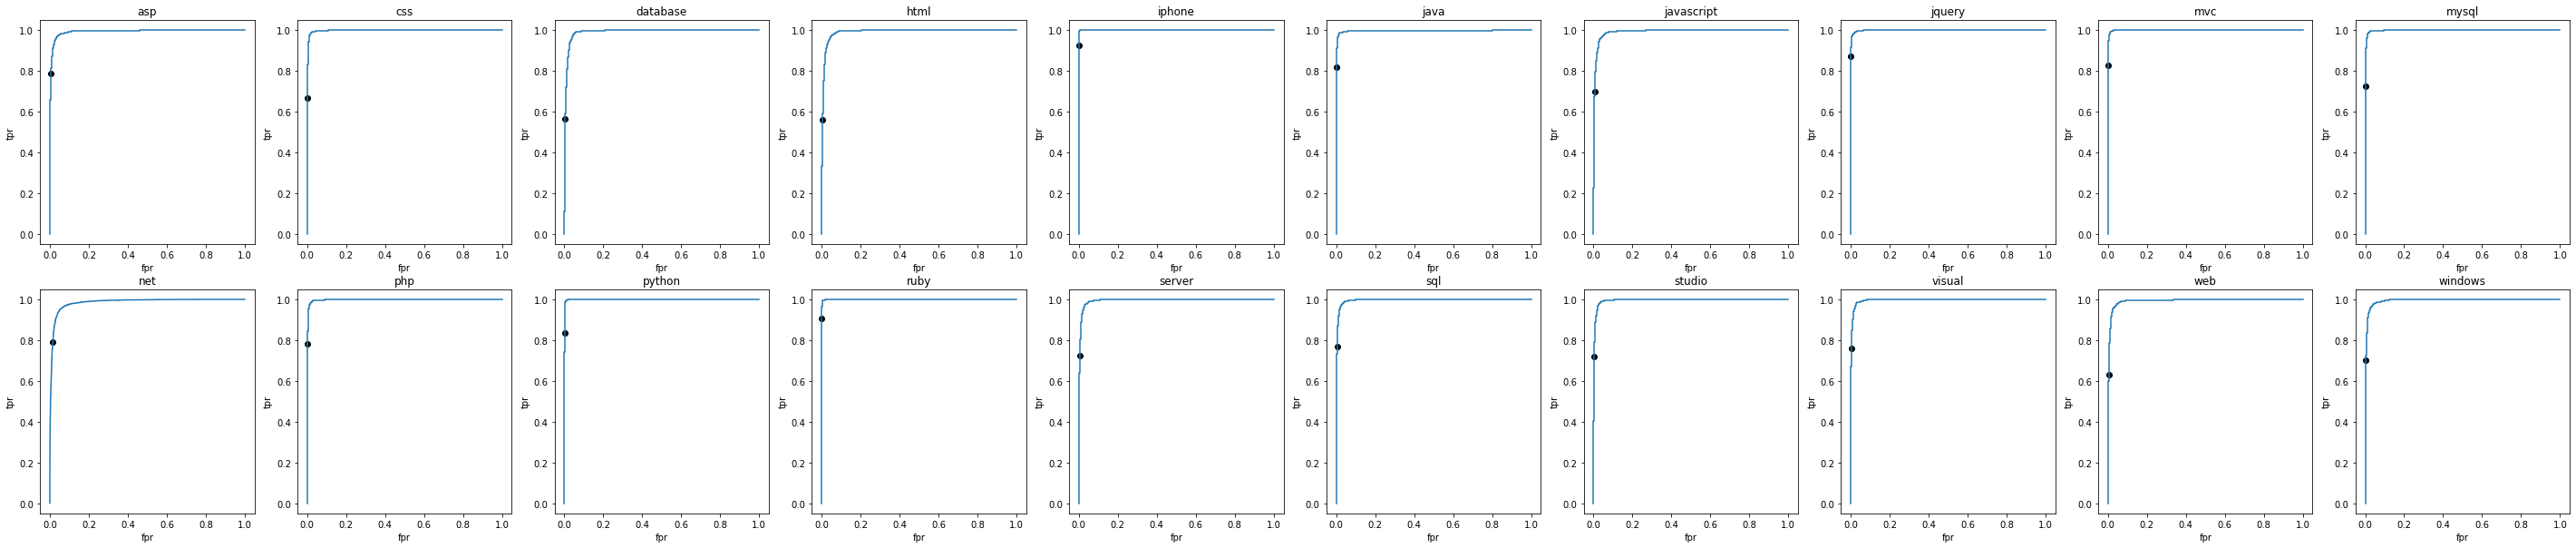

In [522]:
plot_auroc(y_train,y_score_train, labels=tags.columns.tolist())

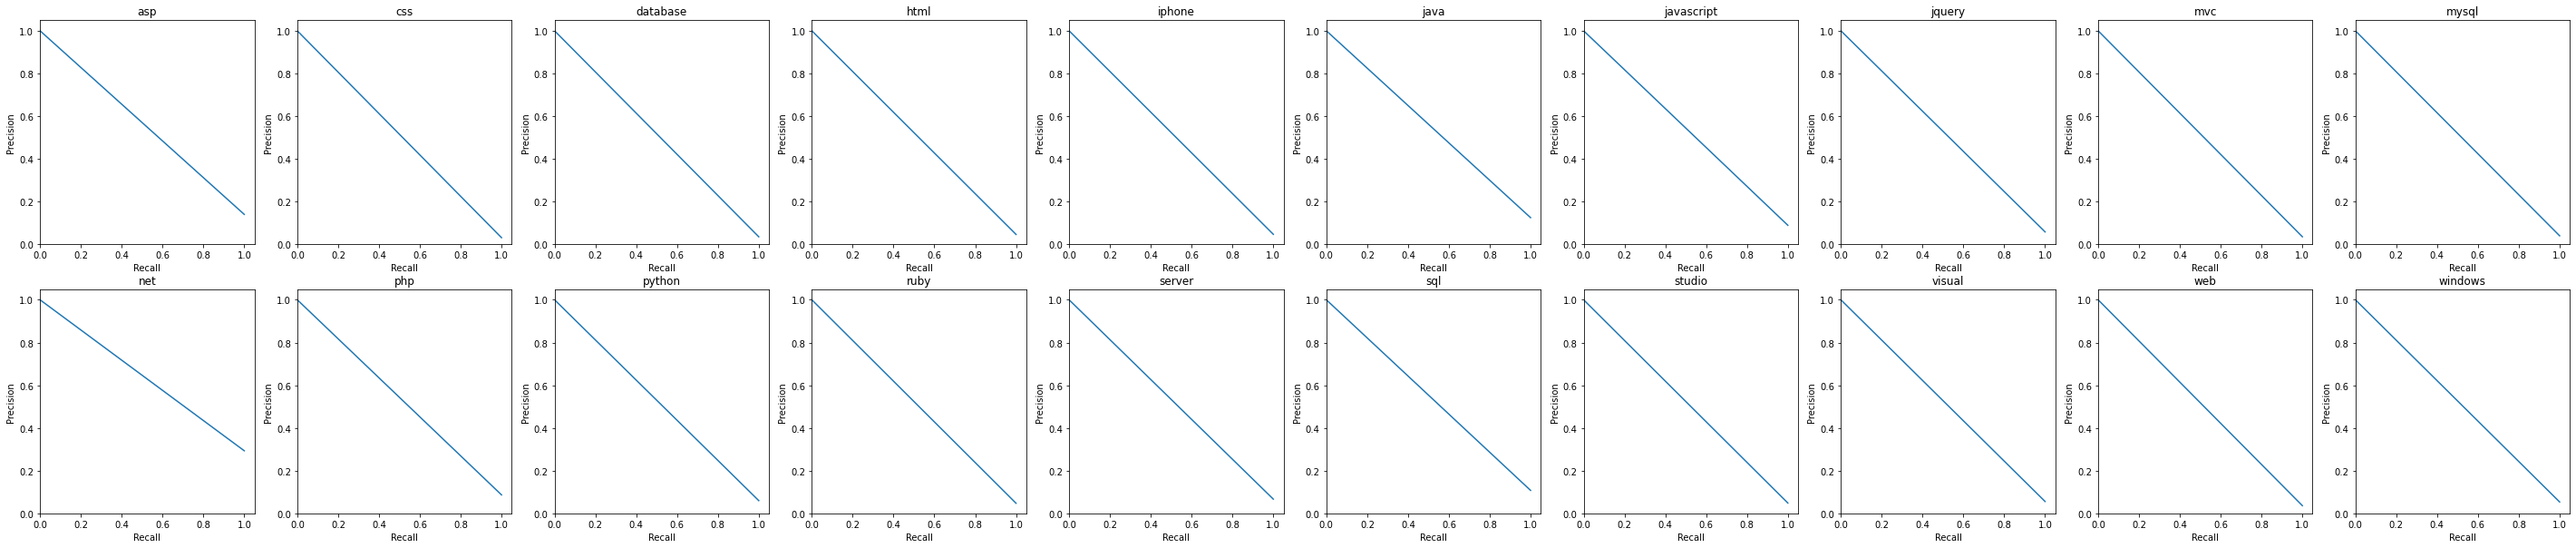

In [491]:
plot_aupr(y_train,y_score_train, labels=tags.columns.tolist())

**1) classification logistic regression**

In [493]:
X_train_tfidf.shape

(16000, 6831)

In [494]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

logistic_regression = LogisticRegression()
logistic_regression = MultiOutputClassifier(logistic_regression)

n_C = 10
estimator__C = np.logspace(0, 1, n_C)

n_jobs=[4]
estimator__max_iter = [400]

hyperparameters = dict(estimator__max_iter = estimator__max_iter,
                       estimator__C = estimator__C,
                       n_jobs = n_jobs
                      )

gscv_logistic_regression = GridSearchCV(logistic_regression, hyperparameters, cv=KFold(4,shuffle=True, random_state=random_state), scoring=scoring , verbose=2)
gscv_logistic_regression.fit(X_train_tfidf, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV] END estimator__C=1.0, estimator__max_iter=400, n_jobs=4; total time=   2.6s
[CV] END estimator__C=1.0, estimator__max_iter=400, n_jobs=4; total time=   1.9s
[CV] END estimator__C=1.0, estimator__max_iter=400, n_jobs=4; total time=   1.8s
[CV] END estimator__C=1.0, estimator__max_iter=400, n_jobs=4; total time=   1.9s
[CV] END estimator__C=1.2915496650148839, estimator__max_iter=400, n_jobs=4; total time=   1.9s
[CV] END estimator__C=1.2915496650148839, estimator__max_iter=400, n_jobs=4; total time=   1.9s
[CV] END estimator__C=1.2915496650148839, estimator__max_iter=400, n_jobs=4; total time=   1.9s
[CV] END estimator__C=1.2915496650148839, estimator__max_iter=400, n_jobs=4; total time=   2.0s
[CV] END estimator__C=1.6681005372000588, estimator__max_iter=400, n_jobs=4; total time=   2.0s
[CV] END estimator__C=1.6681005372000588, estimator__max_iter=400, n_jobs=4; total time=   2.0s
[CV] END estimator__C=1.668100537200058

GridSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
             estimator=MultiOutputClassifier(estimator=LogisticRegression()),
             param_grid={'estimator__C': array([ 1.        ,  1.29154967,  1.66810054,  2.15443469,  2.7825594 ,
        3.59381366,  4.64158883,  5.9948425 ,  7.74263683, 10.        ]),
                         'estimator__max_iter': [400], 'n_jobs': [4]},
             scoring=make_scorer(neg_hamming_loss, needs_proba=True),
             verbose=2)

In [495]:
gscv_logistic_regression.best_estimator_.get_params()

{'estimator__C': 3.5938136638046276,
 'estimator__class_weight': None,
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 400,
 'estimator__multi_class': 'auto',
 'estimator__n_jobs': None,
 'estimator__penalty': 'l2',
 'estimator__random_state': None,
 'estimator__solver': 'lbfgs',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': LogisticRegression(C=3.5938136638046276, max_iter=400),
 'n_jobs': 4}

In [496]:
gscv_logistic_regression.best_params_

{'estimator__C': 3.5938136638046276, 'estimator__max_iter': 400, 'n_jobs': 4}

In [497]:
gscv_logistic_regression.cv_results_

{'mean_fit_time': array([1.82294047, 1.69912088, 1.7666046 , 1.89214474, 2.05543101,
        2.15450078, 2.47601092, 2.43734121, 2.57928473, 2.72991019]),
 'std_fit_time': array([0.32443693, 0.0292104 , 0.03544865, 0.03071064, 0.05515442,
        0.06076151, 0.12086873, 0.05956832, 0.01911604, 0.03986527]),
 'mean_score_time': array([0.33497983, 0.33111012, 0.3298533 , 0.33167082, 0.33118159,
        0.3353498 , 0.35070813, 0.32950932, 0.33281291, 0.32972431]),
 'std_score_time': array([0.00372384, 0.00461624, 0.00364049, 0.01325363, 0.00917693,
        0.00785294, 0.01508928, 0.00328398, 0.00551557, 0.0045188 ]),
 'param_estimator__C': masked_array(data=[1.0, 1.2915496650148839, 1.6681005372000588,
                    2.154434690031884, 2.7825594022071245,
                    3.5938136638046276, 4.641588833612778,
                    5.994842503189409, 7.742636826811269, 10.0],
              mask=[False, False, False, False, False, False, False, False,
                    False, False

In [498]:
y_score_train = gscv_logistic_regression.predict_proba(X_train_tfidf)
y_pred_train = gscv_logistic_regression.predict(X_train_tfidf)

classification_report = classification_report.append(get_metrics(y_train, y_score_train, 'logistic_regression_on_train'))

In [499]:
y_score_val = gscv_logistic_regression.predict_proba(X_val_tfidf)
y_pred_val = gscv_logistic_regression.predict(X_val_tfidf)
classification_report = classification_report.append(get_metrics(y_val, y_score_val, 'logistic_regression_on_val'))

**courbe neg hamming loss**

with threshold =  0.30303030303030304
best neg_hamming_loss =  -0.015840625


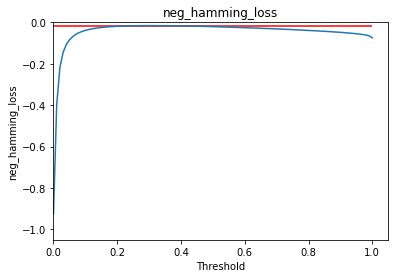

In [506]:
plot_neg_hamming_loss(y_train,y_score_train)

with threshold =  0.29292929292929293
best neg_hamming_loss =  -0.033075


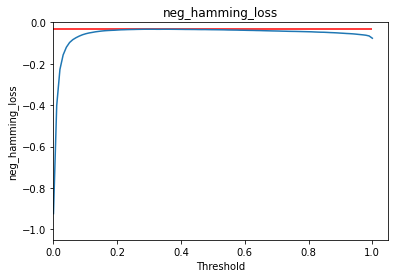

In [507]:
plot_neg_hamming_loss(y_val,y_score_val)

In [ ]:
threshold=0.30303030303030304

**courbe ROC pour chaques étiquettes**

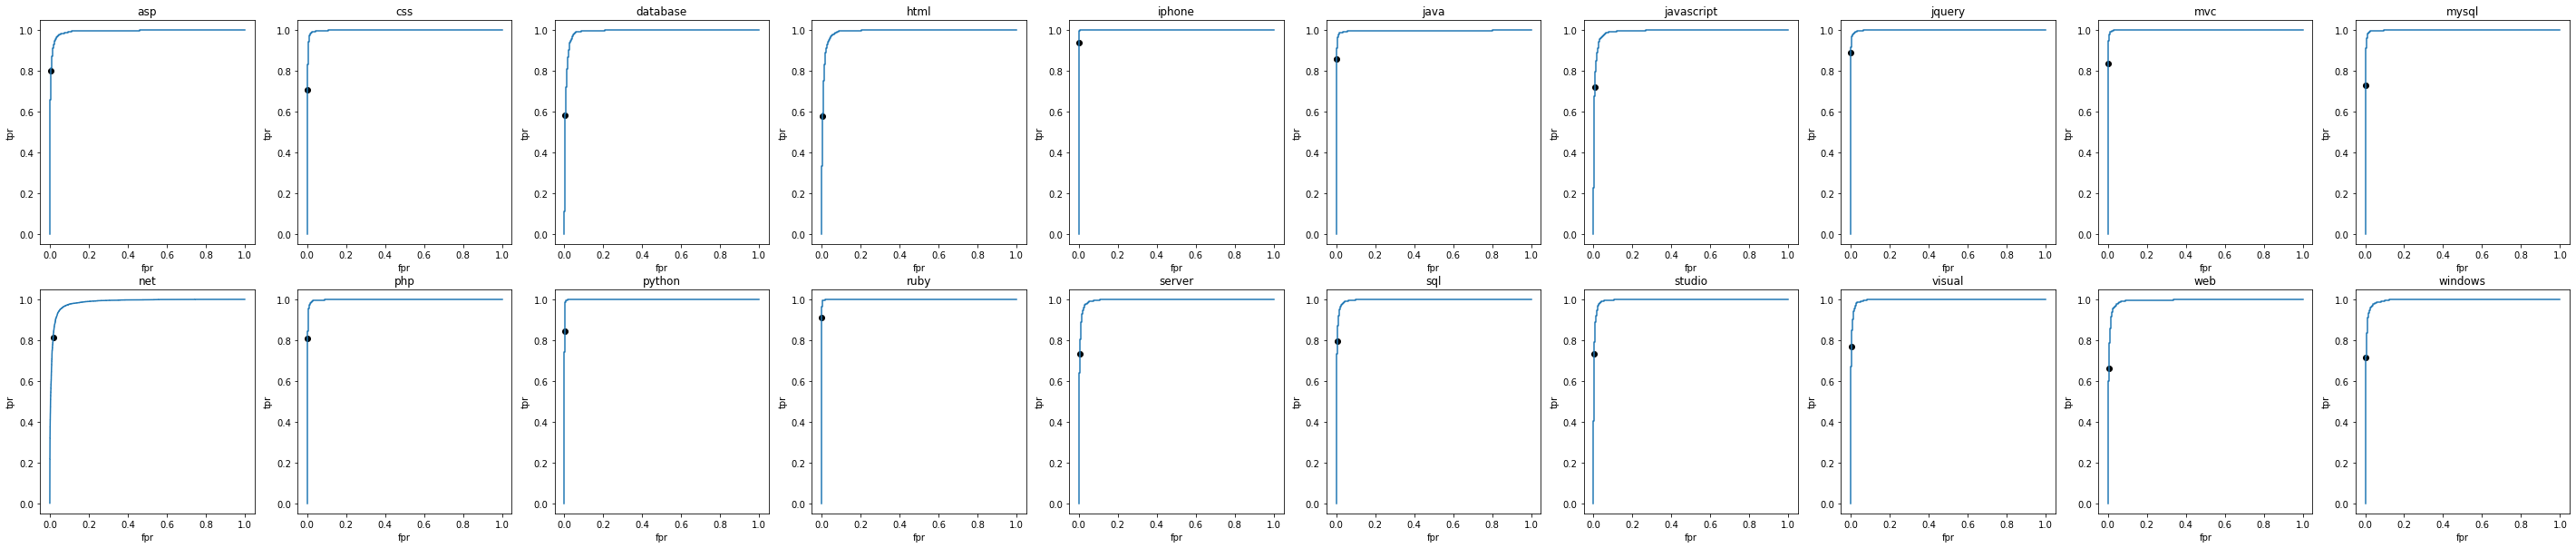

In [523]:
plot_auroc(y_train,y_score_train, threshold=threshold,  labels=tags.columns.tolist())

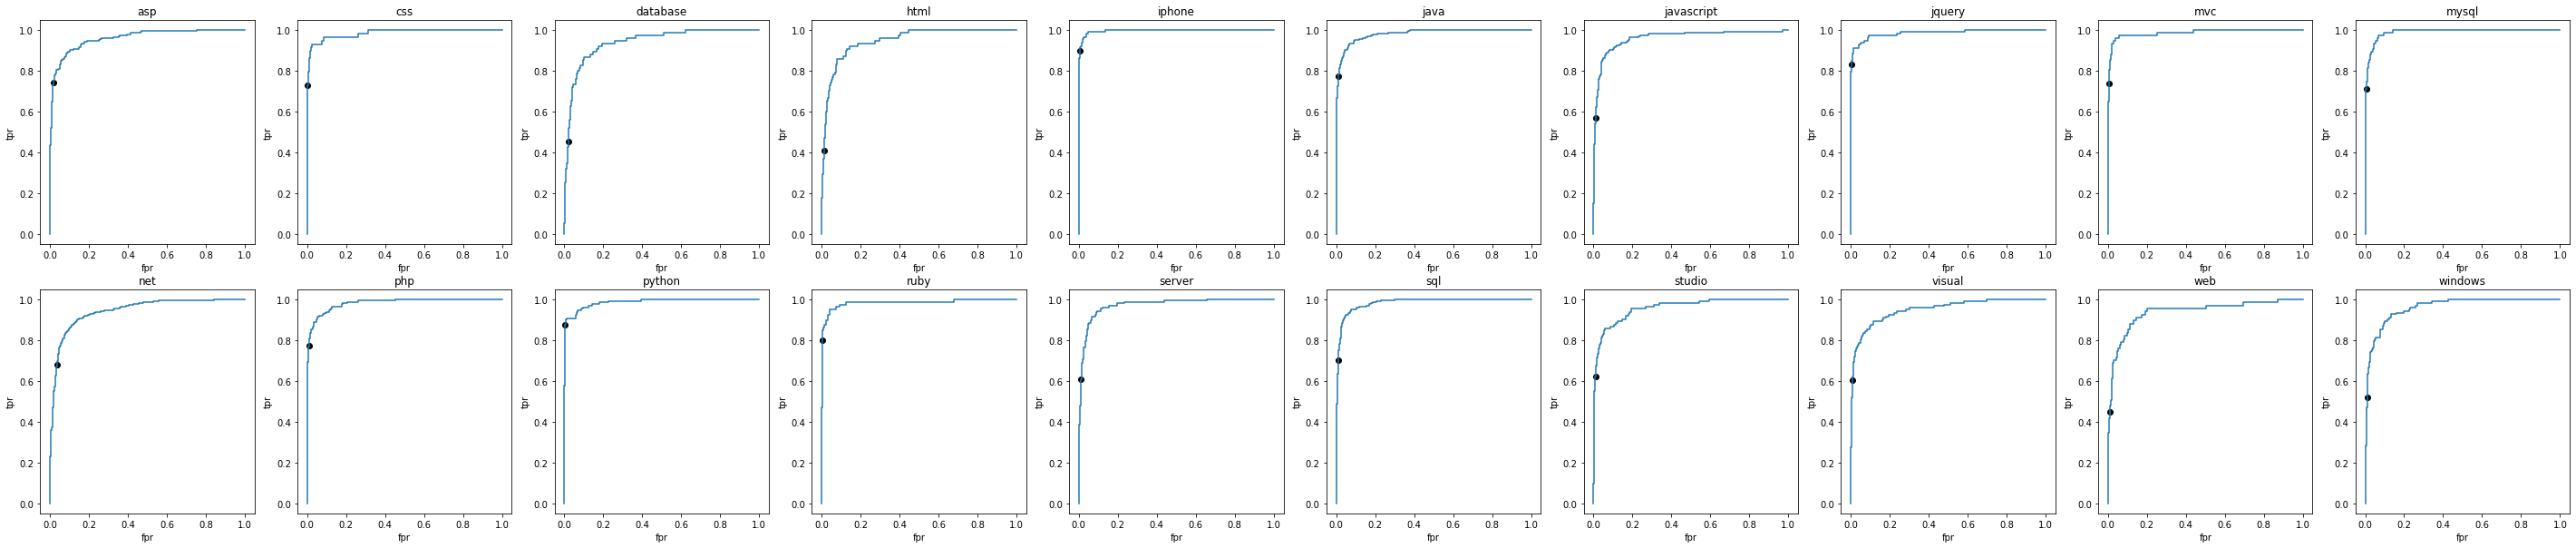

In [524]:
plot_auroc(y_val,y_score_val, threshold=threshold, labels=tags.columns.tolist())

**courbe precision-recall pour chaques étiquettes**

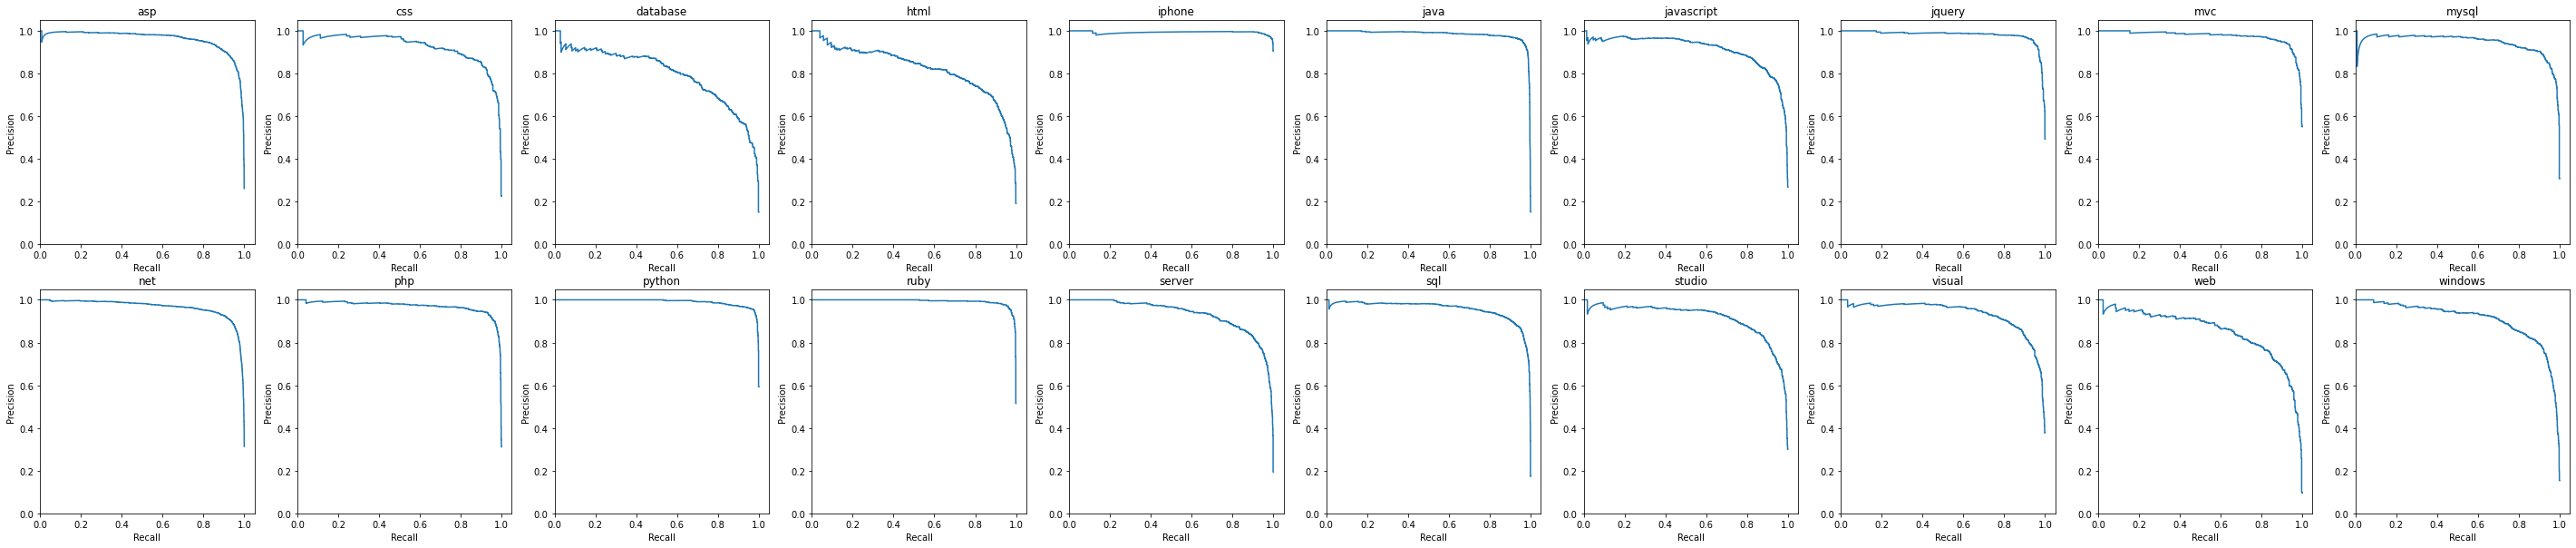

In [502]:
plot_aupr(y_train,y_score_train, labels=tags.columns.tolist())

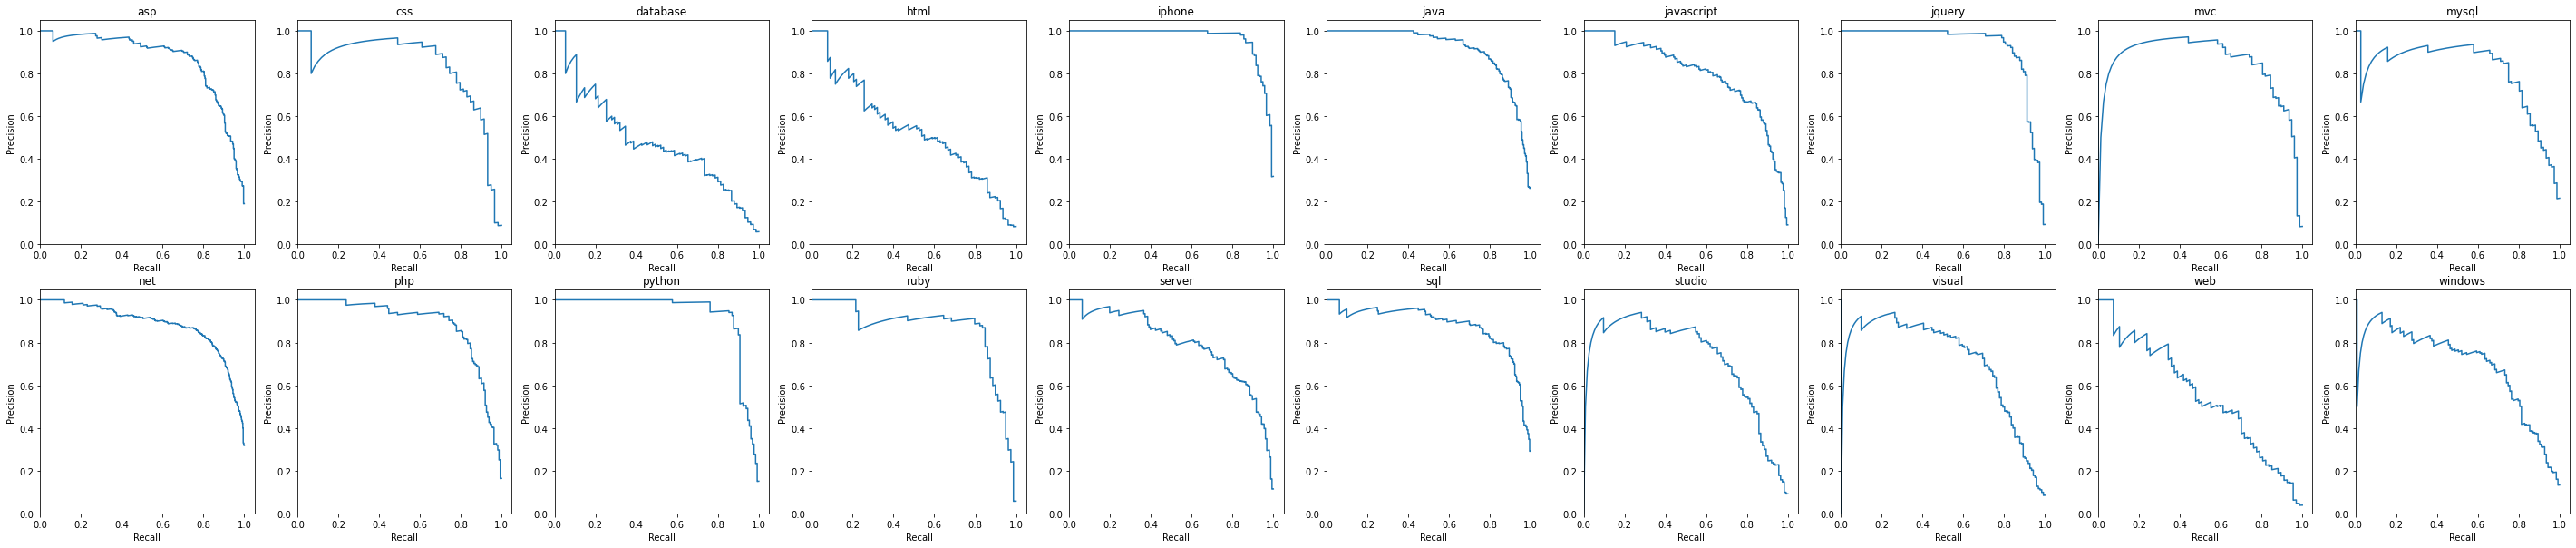

In [503]:
plot_aupr(y_val,y_score_val, labels=tags.columns.tolist())

**courbe accuracy pour chaques étiquettes**

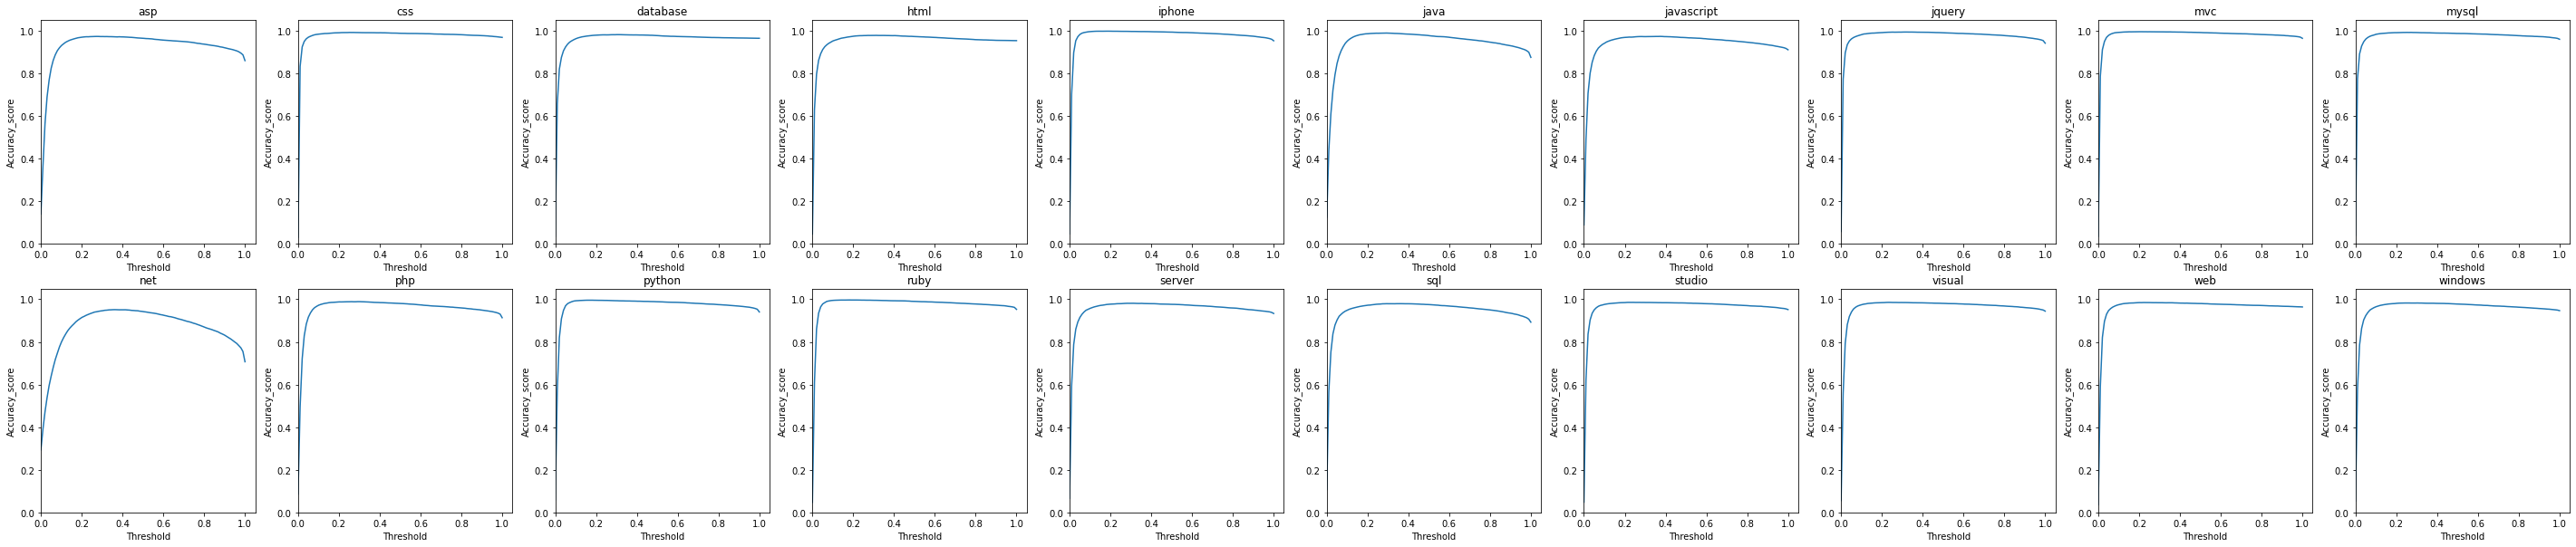

with threshold =  0.33333333333333337
best average accuracy weighted score =  0.9773828756142253


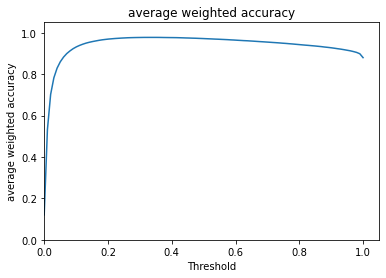

In [504]:
plot_accuracy(y_train,y_score_train, labels=tags.columns.tolist())

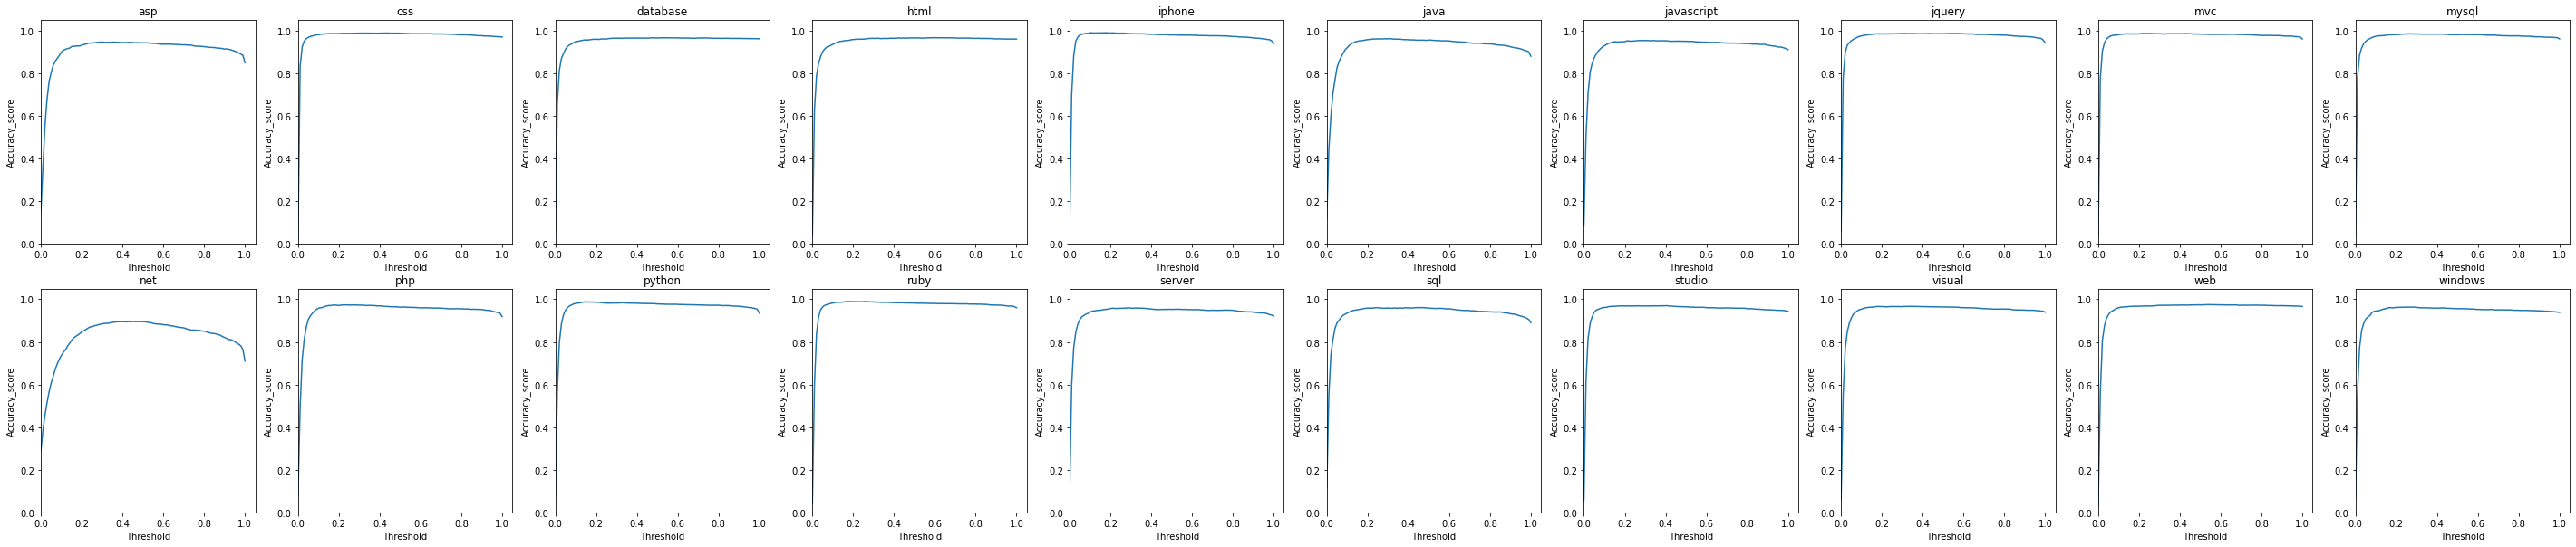

with threshold =  0.36363636363636365
best average accuracy weighted score =  0.9524531810766721


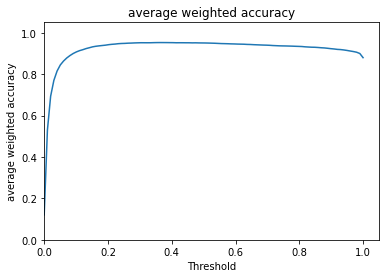

In [505]:
plot_accuracy(y_val,y_score_val, labels=tags.columns.tolist())

**courbe jaccard**

with threshold =  0.2828282828282829
best jaccard score =  0.8149491712263094


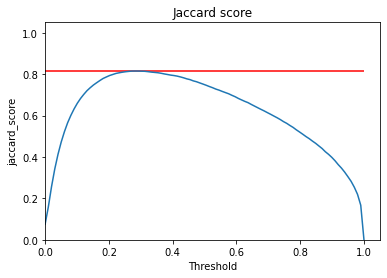

In [508]:
plot_jaccard(y_train,y_score_train)

with threshold =  0.29292929292929293
best jaccard score =  0.6432677399835268


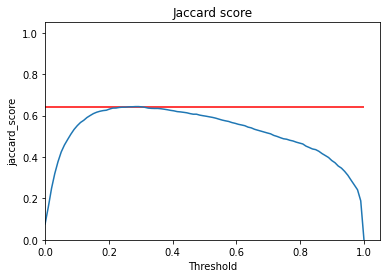

In [509]:
plot_jaccard(y_val,y_score_val)

**matrice de confusion**

In [427]:
threshold=0.2828282828282829

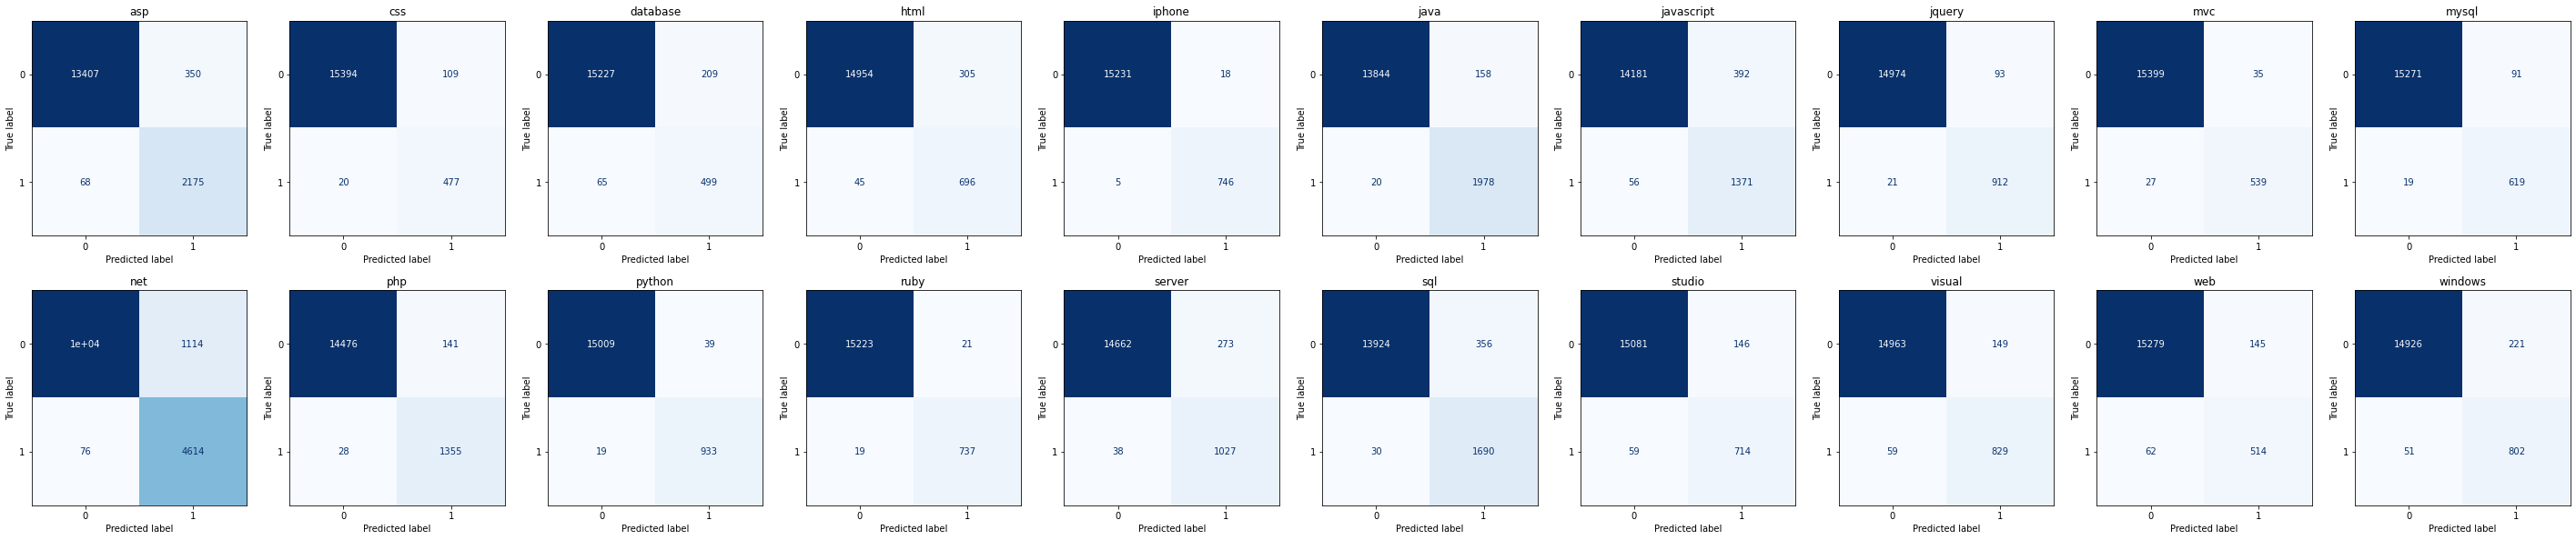

In [428]:
plot_matconf(y_train, y_score_train, threshold=threshold, labels=tags.columns.tolist())

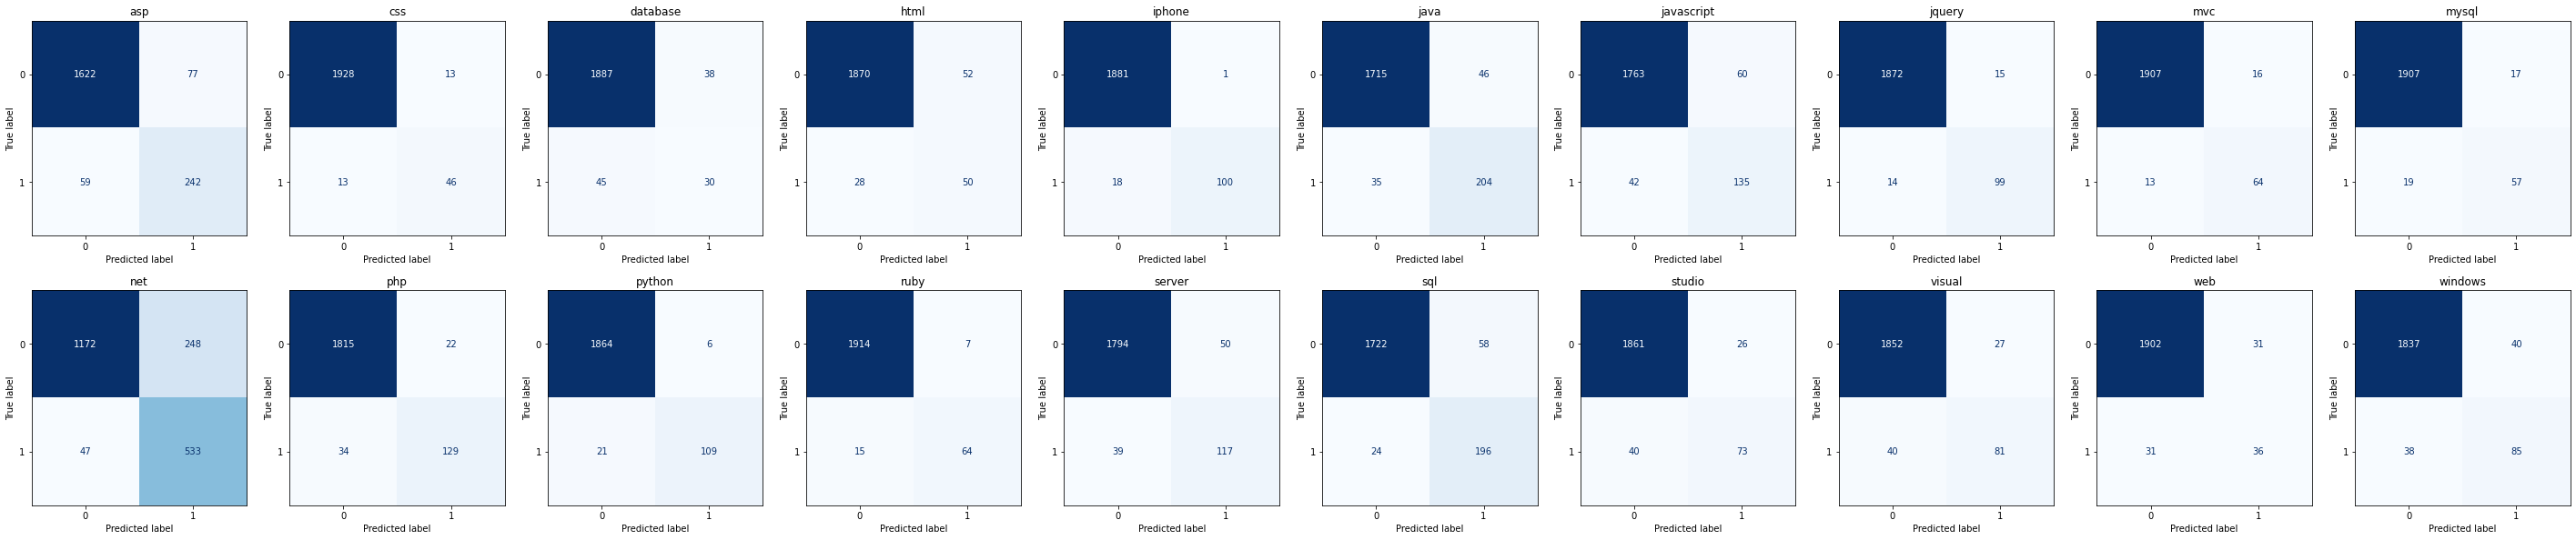

In [429]:
plot_matconf(y_val, y_score_val, threshold=threshold, labels=tags.columns.tolist())

**1) classification Random Forest**

In [112]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

random_forest = RandomForestClassifier()

n_estimators = [int(x) for x in np.linspace(start = 400, stop = 1000, num = 3)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(3, 30, num = 5)]
#max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

hyperparameters = dict(n_estimators = n_estimators,
                       max_features = max_features,
                       max_depth = max_depth,
                       min_samples_split = min_samples_split,
                       min_samples_leaf = min_samples_leaf,
                       bootstrap = bootstrap,
                       n_jobs = n_jobs
                      )

rscv_random_forest = RandomizedSearchCV(random_forest, hyperparameters, n_iter = 50, cv=KFold(3,shuffle=True, random_state=random_state), verbose=2 , random_state=random_state, scoring=scoring)

rscv_random_forest.fit(X_train_tfidf, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=700, n_jobs=4; total time=   6.5s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=700, n_jobs=4; total time=   5.3s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=700, n_jobs=4; total time=   5.3s
[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=700, n_jobs=4; total time=   3.5s
[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=700, n_jobs=4; total time=   3.3s
[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=700, n_jobs=4; total time=   3.2s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_sa

[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=700, n_jobs=4; total time=   7.1s
[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=700, n_jobs=4; total time=   3.5s
[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=700, n_jobs=4; total time=   3.4s
[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=700, n_jobs=4; total time=   3.4s
[CV] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=700, n_jobs=4; total time=   3.6s
[CV] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=700, n_jobs=4; total time=   3.7s
[CV] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=700, n_jobs=4;

[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400, n_jobs=4; total time=   2.0s
[CV] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400, n_jobs=4; total time=   2.0s
[CV] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=700, n_jobs=4; total time=   5.1s
[CV] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=700, n_jobs=4; total time=   5.1s
[CV] END bootstrap=True, max_depth=23, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=700, n_jobs=4; total time=   5.3s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=700, n_jobs=4; total time=   5.1s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=700, n_jo

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(), n_iter=50,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 9, 16, 23, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [400, 700, 1000],
                                        'n_jobs': [4]},
                   random_state=42,
                   scoring=make_scorer(neg_hamming_loss, needs_proba=True),
                   verbose=2)

In [131]:
rscv_random_forest.cv_results_

{'mean_fit_time': array([ 4.39775157,  1.96756554,  9.64740483,  3.10763232,  4.84151308,
         2.83480549,  0.92766015,  3.73835325,  1.44677313,  5.78315337,
         0.8733952 ,  1.66917658,  5.79988782,  1.19213518,  2.13301206,
         2.21685568,  9.51078391,  2.91386509,  5.89805317,  2.14161253,
         2.40016373,  4.43360146,  1.68676281,  5.63470022,  6.25608985,
         2.01995444,  1.82557138,  1.55022701,  1.55766273,  2.14281495,
         3.5054632 ,  4.94865163,  7.6733586 ,  7.94256369,  2.43282199,
         8.38815276,  2.2473712 ,  1.21159577,  3.86560186,  3.6914986 ,
         0.95565502, 11.03001308,  4.40213386,  4.45357124,  5.03953624,
         2.07604122,  3.72460914,  2.06619771,  7.2215093 ,  0.8853116 ]),
 'std_fit_time': array([0.57181883, 0.04333241, 0.10401232, 0.0517444 , 0.01976198,
        0.00628656, 0.00529302, 0.01726321, 0.01093997, 0.02264006,
        0.00507696, 0.01551275, 0.03281166, 0.01395275, 0.02322147,
        0.01515892, 0.06551676,

In [132]:
y_score_train = rscv_random_forest.best_estimator_.predict_proba(X_train_tfidf)
y_pred_train = rscv_random_forest.best_estimator_.predict(X_train_tfidf)
classification_report = classification_report.append(get_metrics(y_train, y_score_train, 'random_forest_on_train'))

In [133]:
y_score_val = rscv_random_forest.best_estimator_.predict_proba(X_val_tfidf)
y_pred_val = rscv_random_forest.best_estimator_.predict(X_val_tfidf)
classification_report = classification_report.append(get_metrics(y_val, y_score_val, 'random_forest_on_val'))

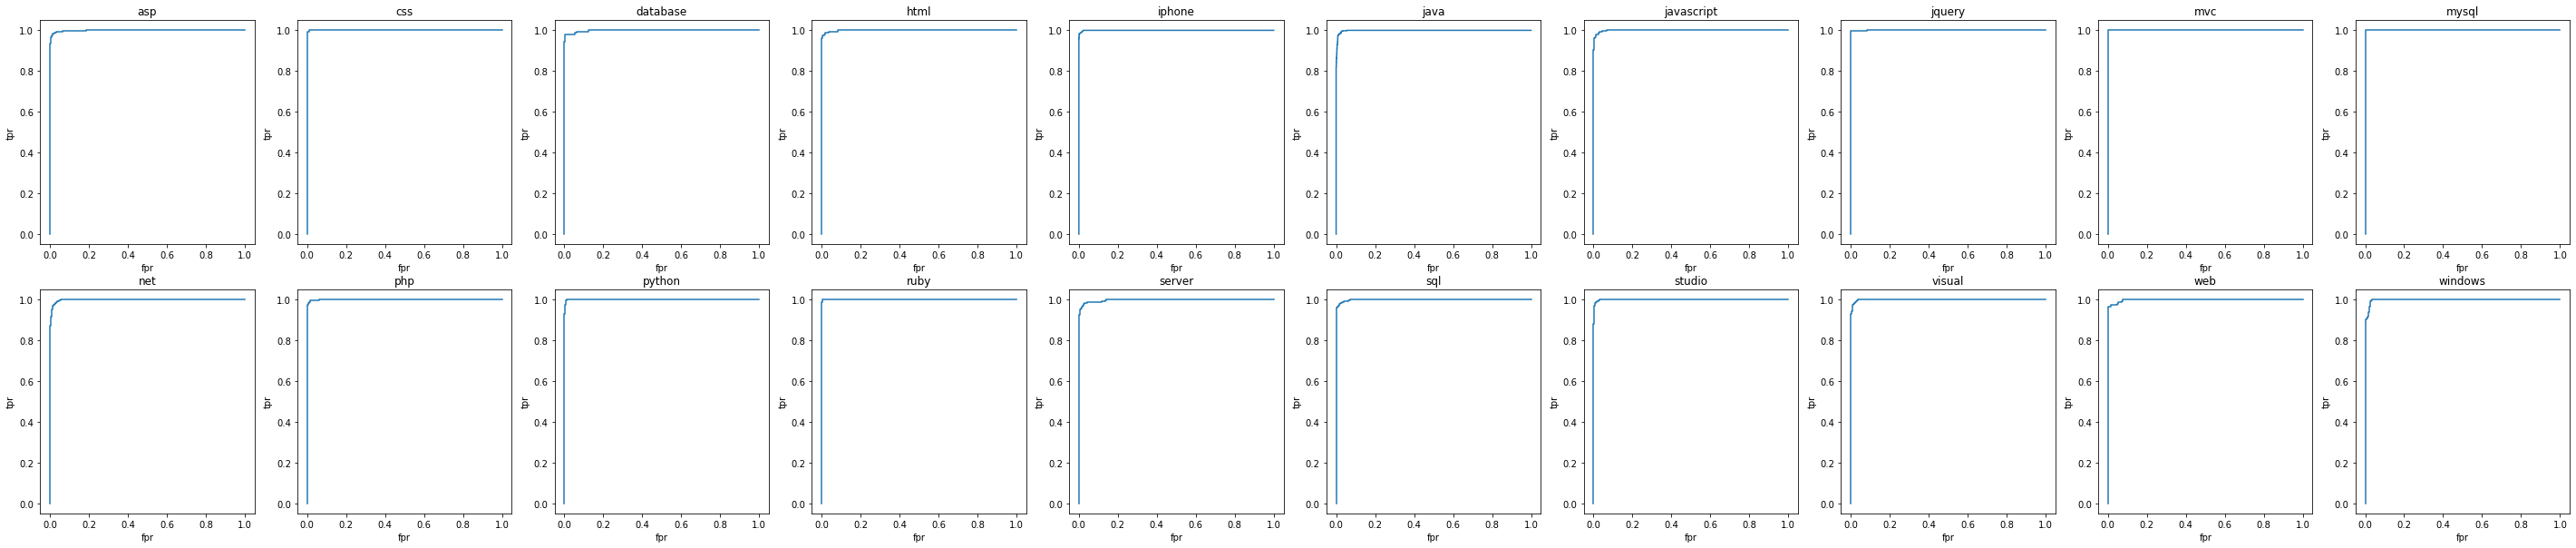

In [134]:
plot_auroc(y_train,y_score_train, labels=tags.columns.tolist())

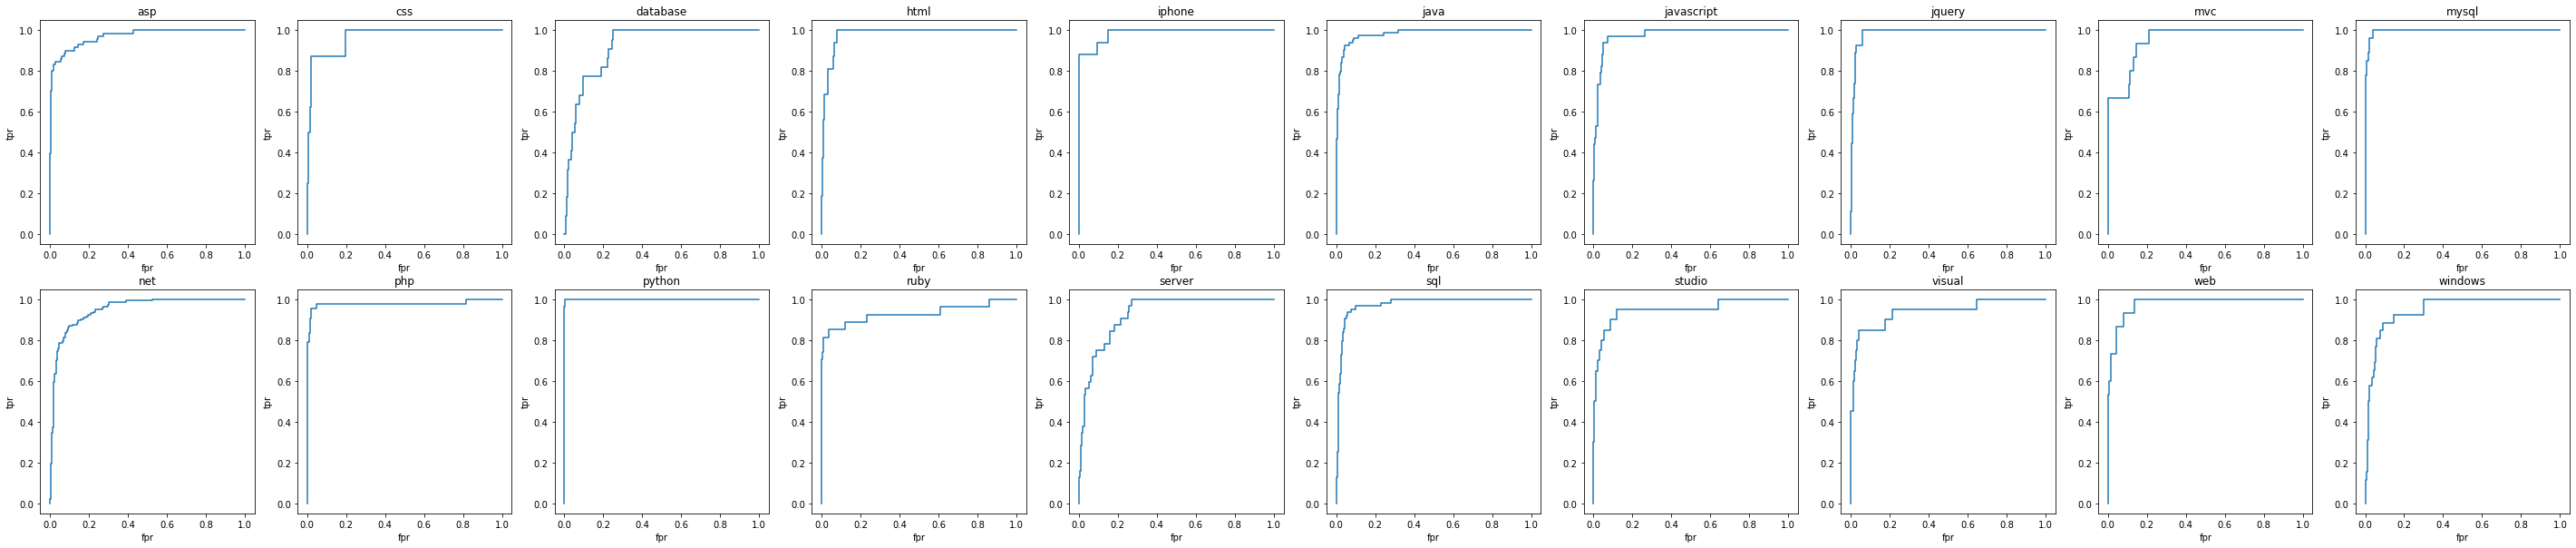

In [135]:
plot_auroc(y_val,y_score_val, labels=tags.columns.tolist())

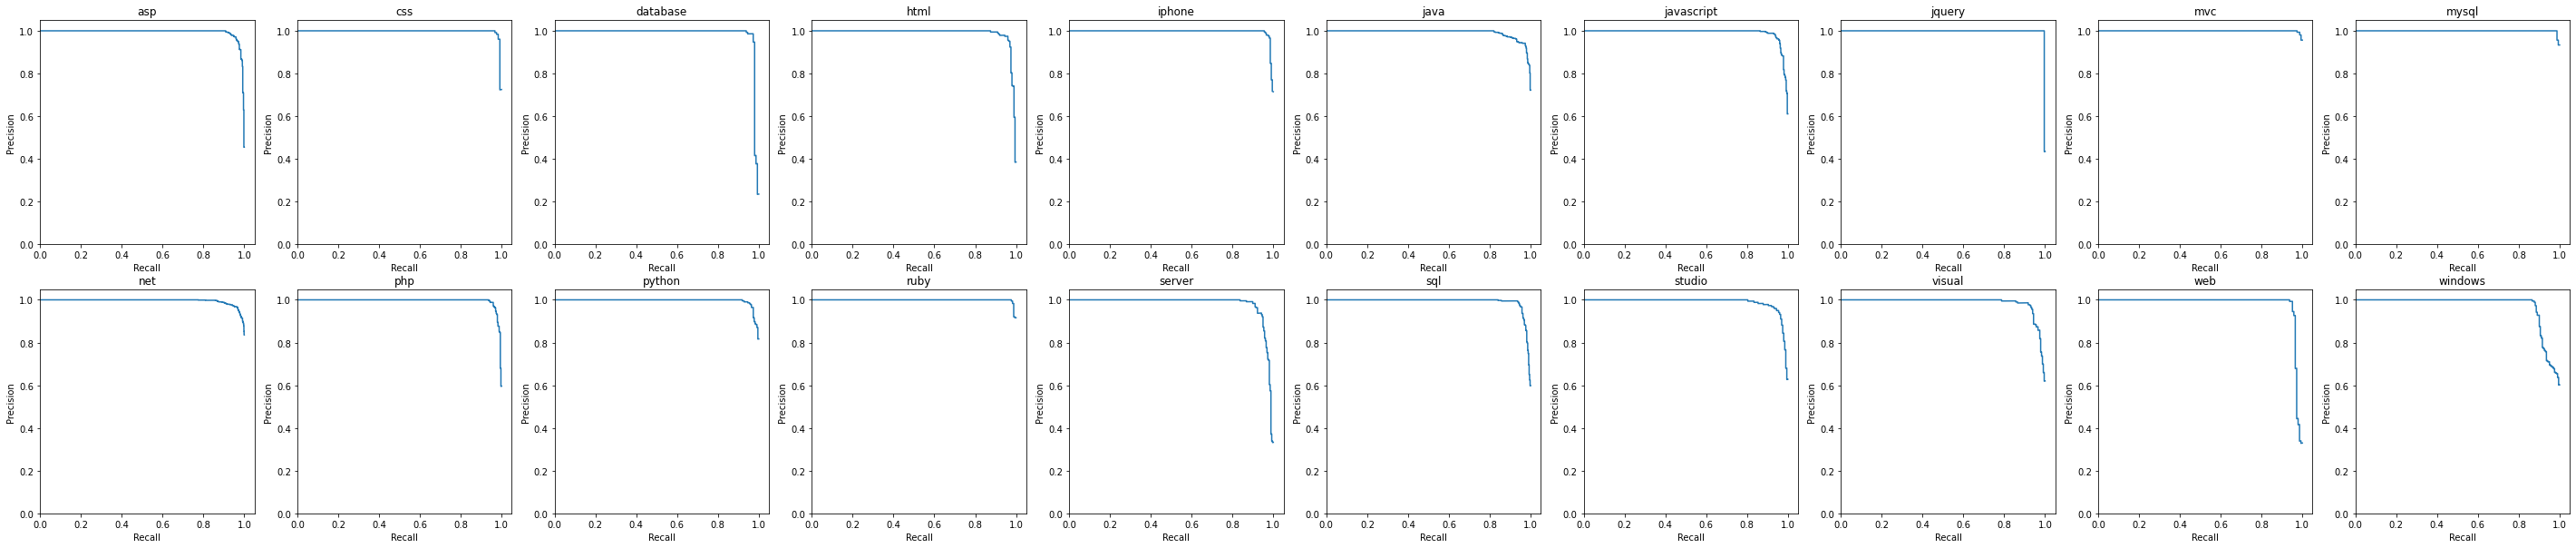

In [136]:
plot_aupr(y_train,y_score_train, labels=tags.columns.tolist())

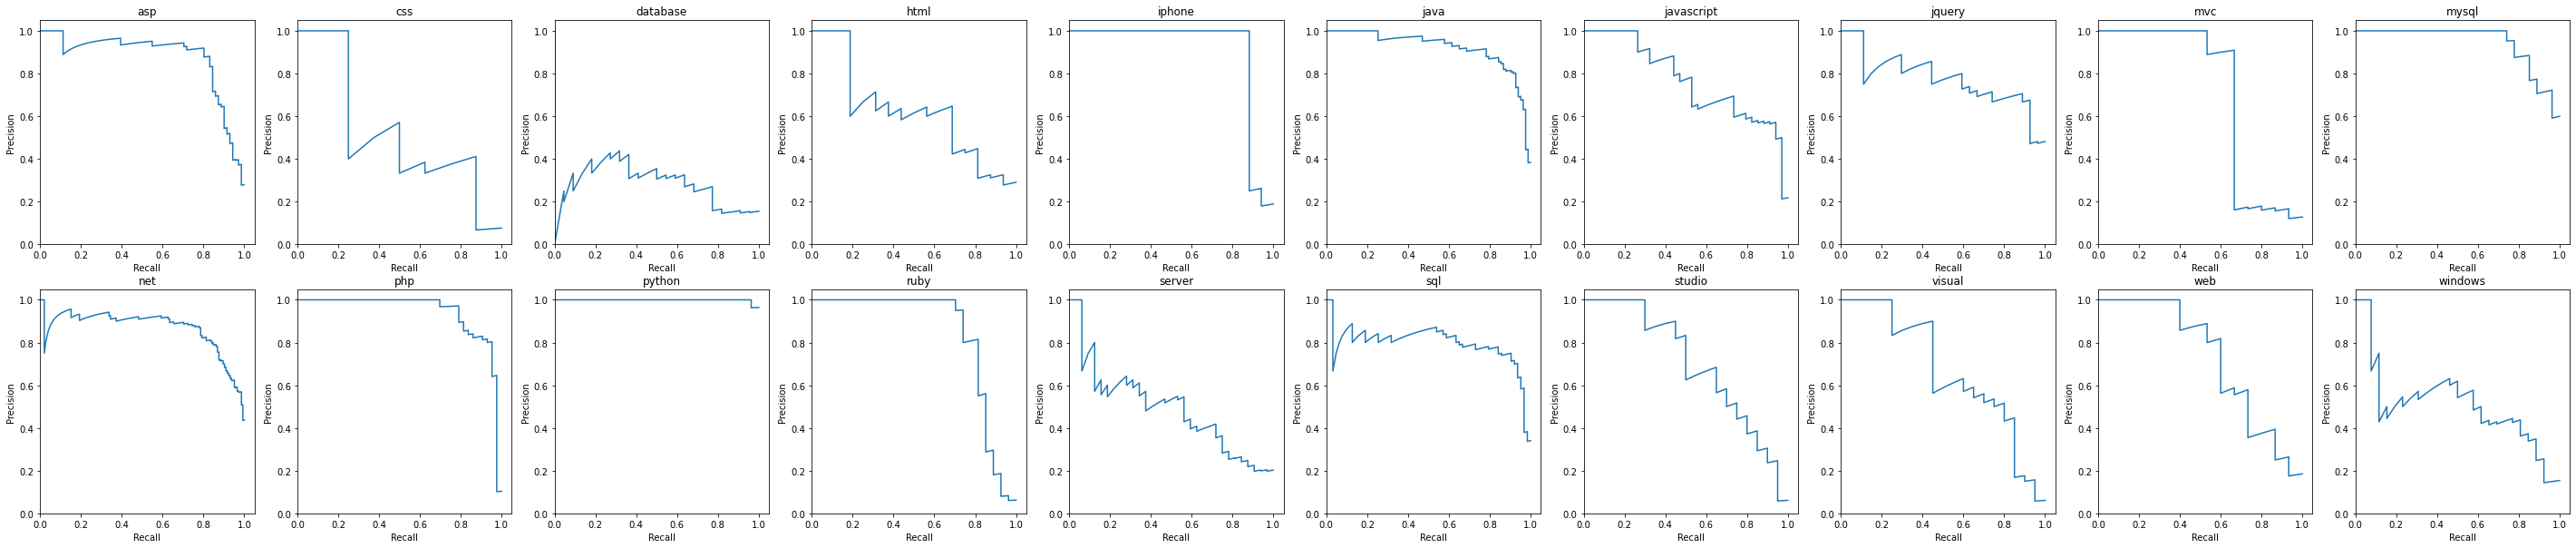

In [137]:
plot_aupr(y_val,y_score_val, labels=tags.columns.tolist())

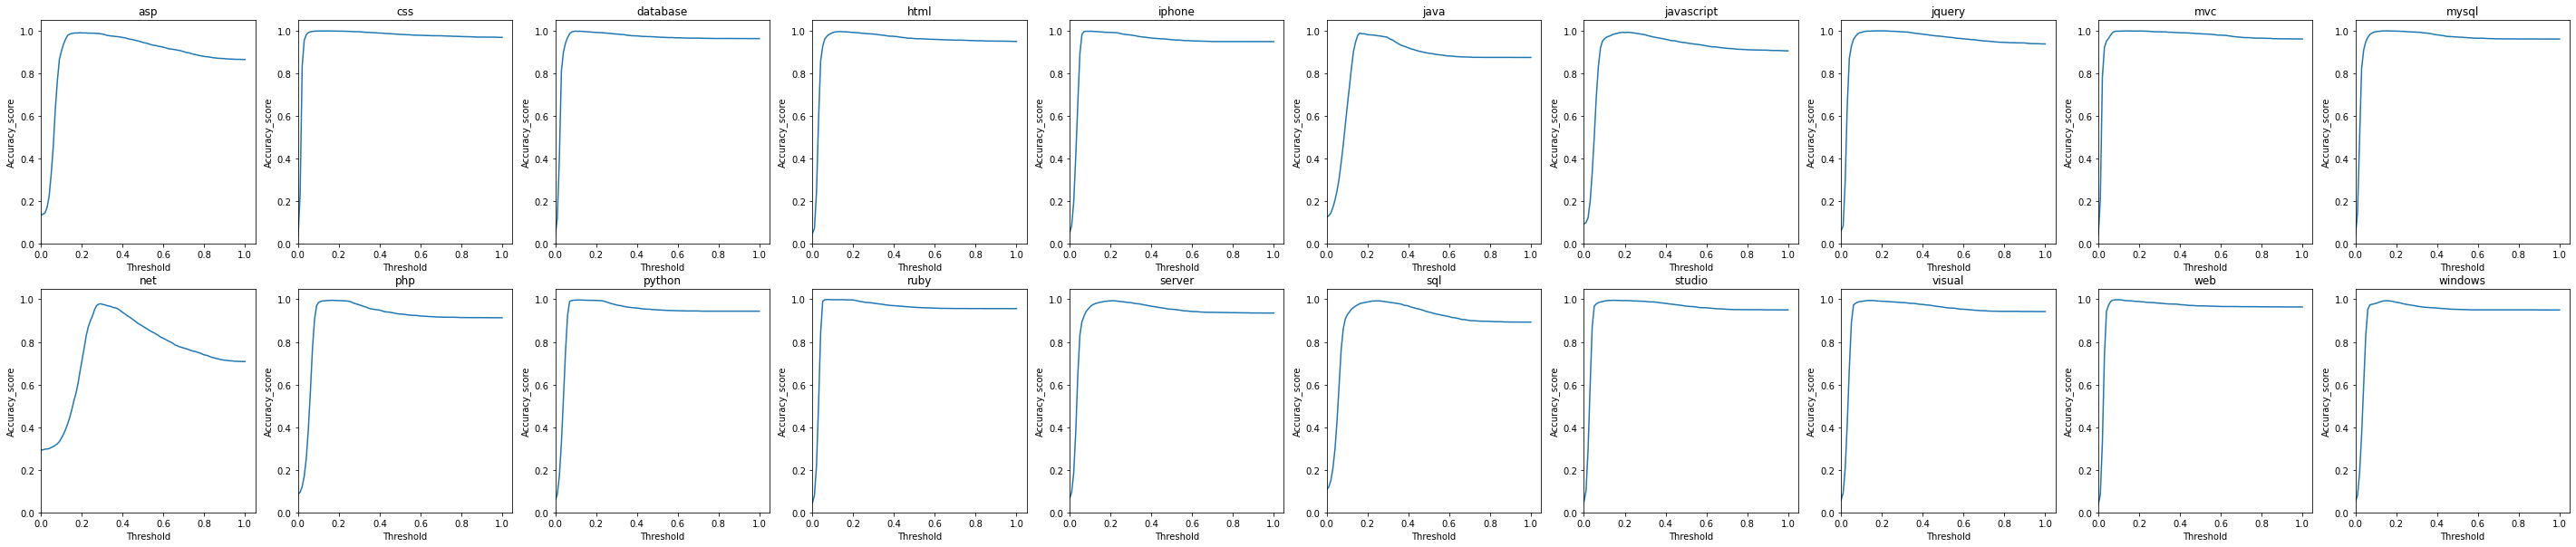

with threshold =  0.2828282828282829
best average accuracy weighted score =  0.9830034883720932


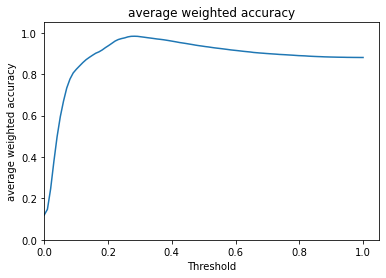

In [138]:
plot_accuracy(y_train,y_score_train, labels=tags.columns.tolist())

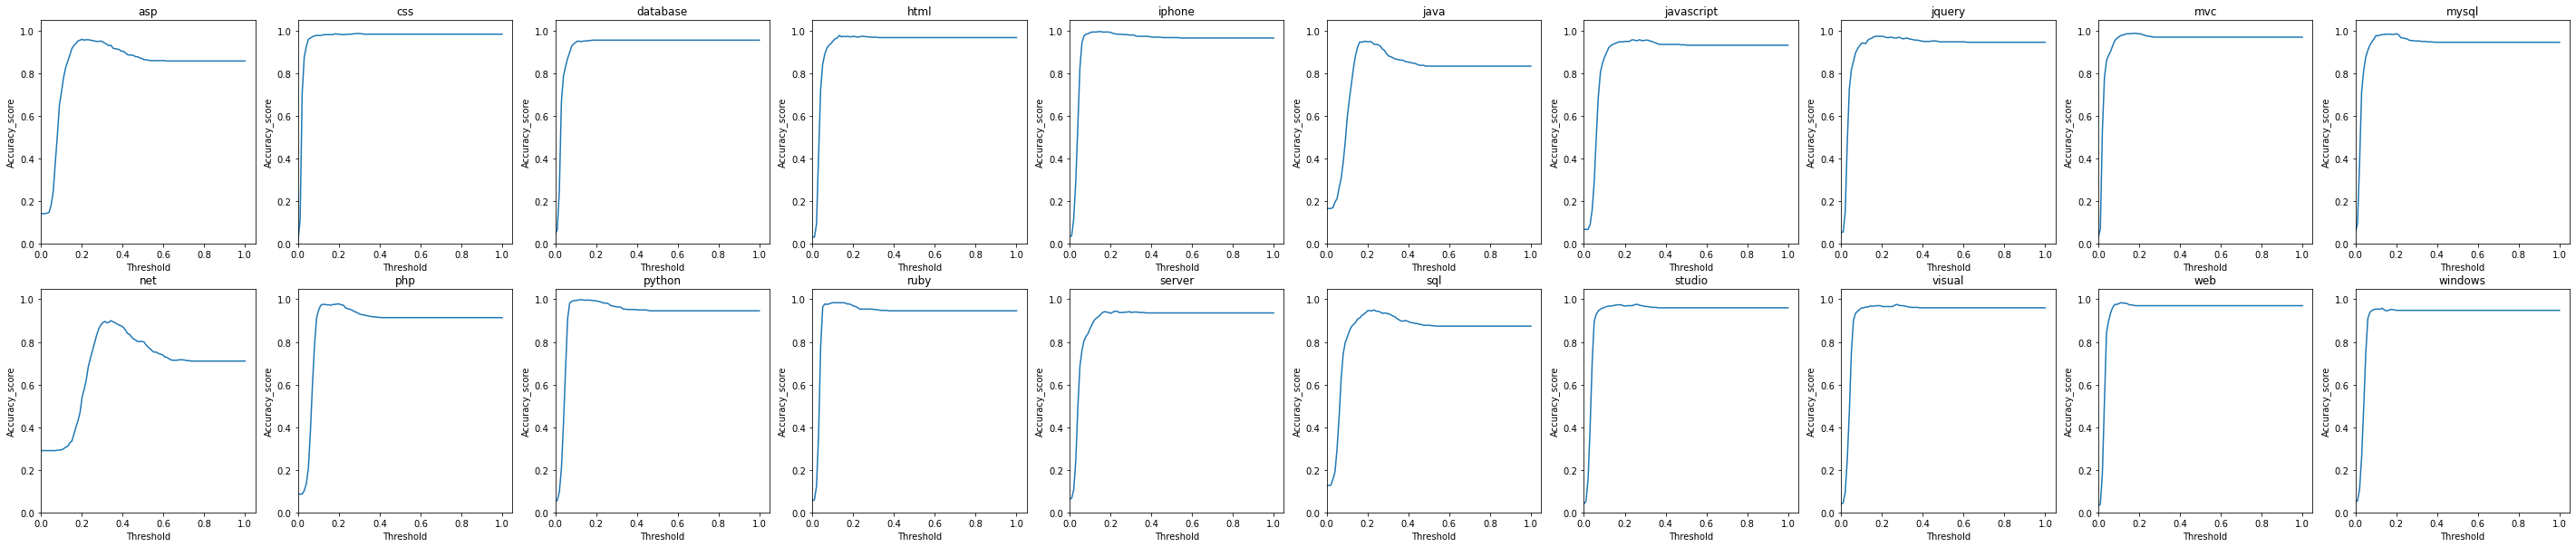

with threshold =  0.29292929292929293
best average accuracy weighted score =  0.9320569105691057


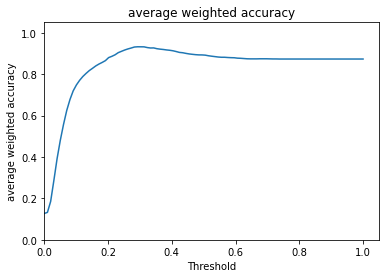

In [139]:
plot_accuracy(y_val,y_score_val, labels=tags.columns.tolist())

with threshold =  0.26262626262626265
best neg_hamming_loss =  -0.014025


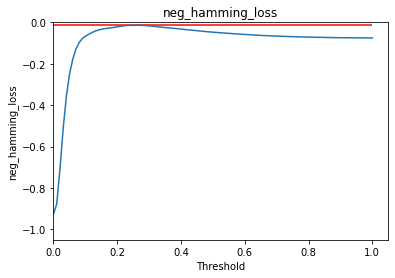

In [140]:
plot_neg_hamming_loss(y_train,y_score_train)

with threshold =  0.2828282828282829
best neg_hamming_loss =  -0.0471


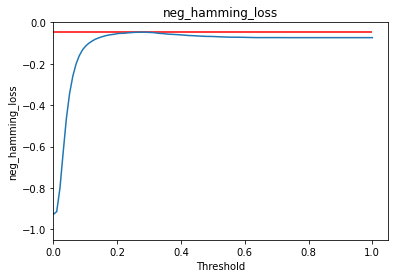

In [141]:
plot_neg_hamming_loss(y_val,y_score_val)

with threshold =  0.26262626262626265
best jaccard score =  0.8334169388765863


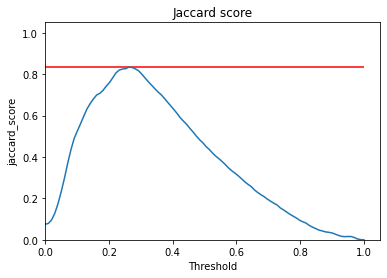

In [142]:
plot_jaccard(y_train,y_score_train)

with threshold =  0.2828282828282829
best jaccard score =  0.5543493961140372


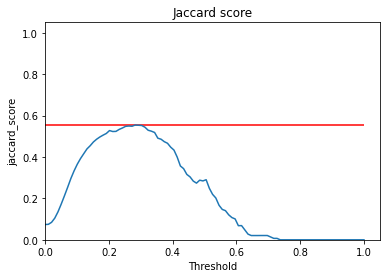

In [143]:
plot_jaccard(y_val,y_score_val)

**matrice de confusion**

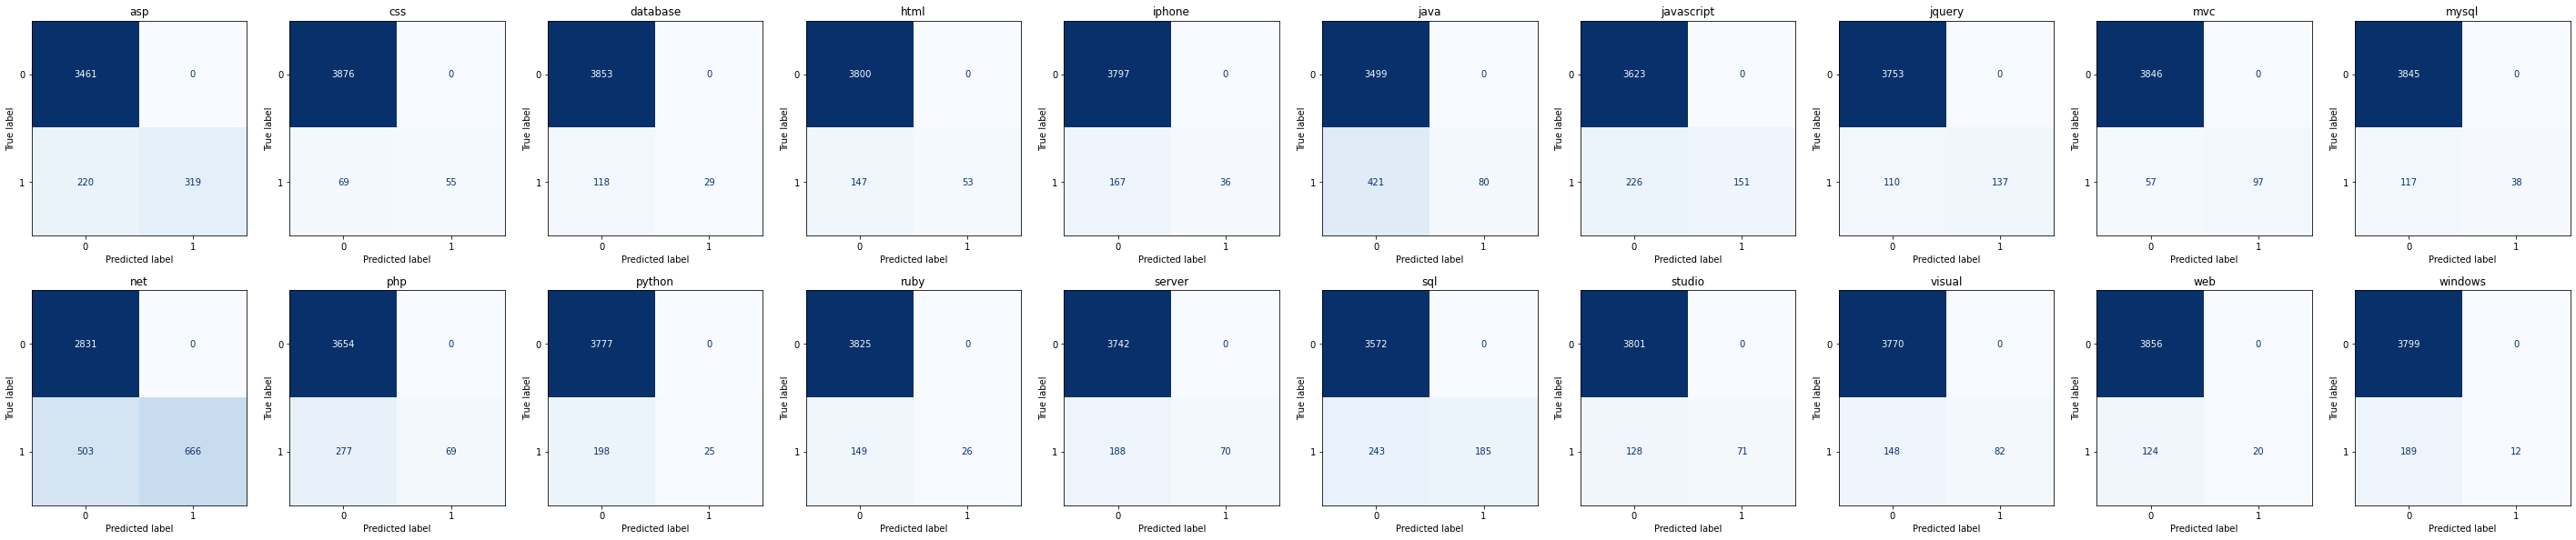

In [144]:
plot_matconf(y_train,y_pred_train, labels=tags.columns.tolist())

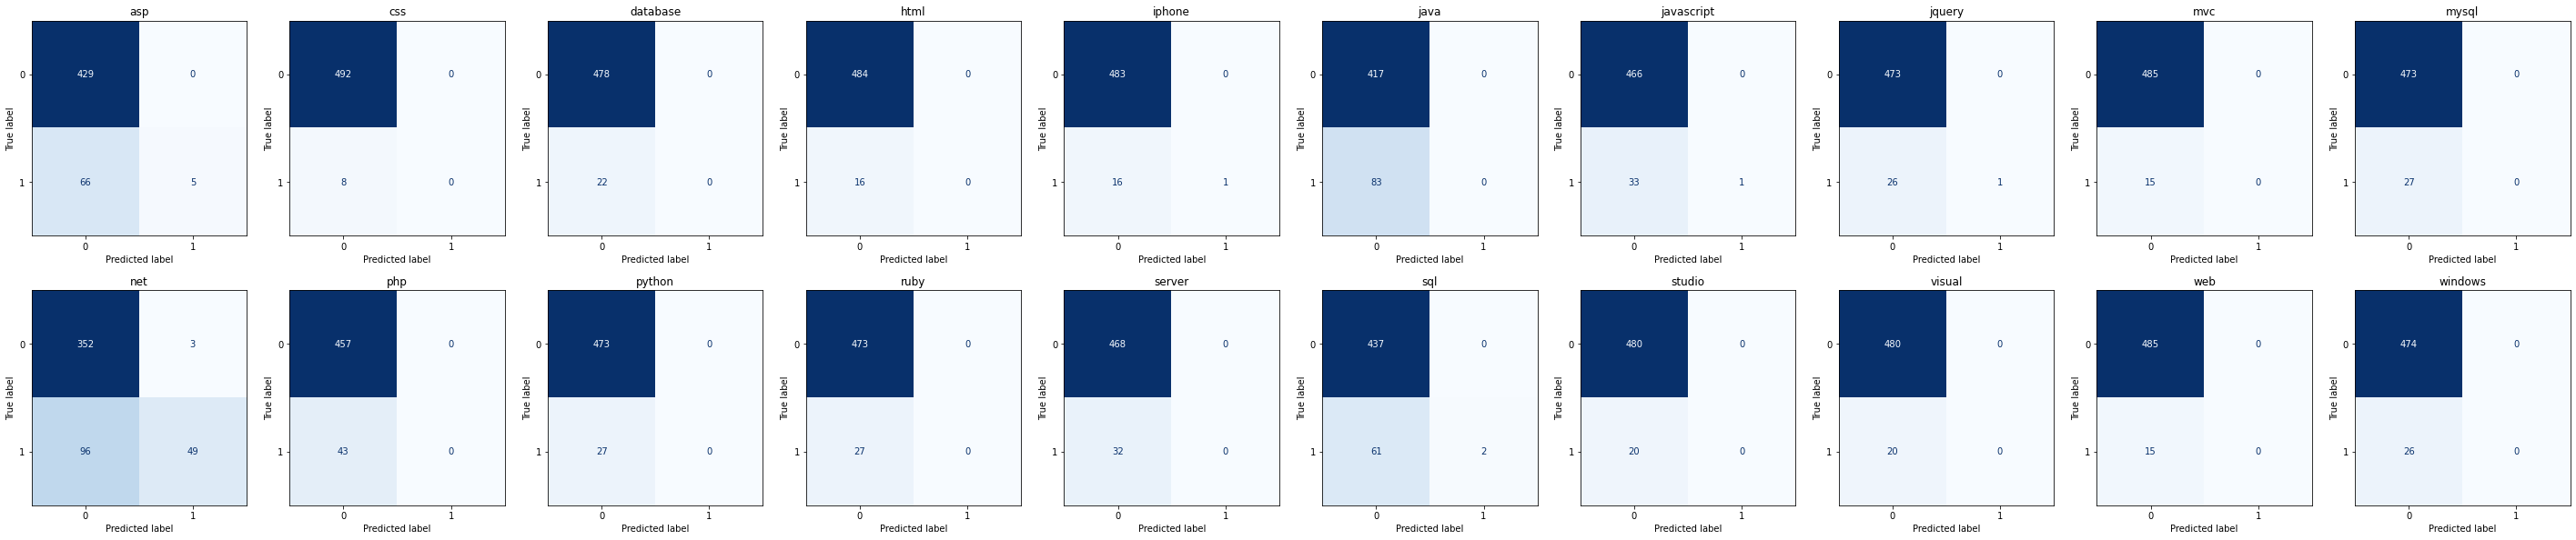

In [145]:
plot_matconf(y_val,y_pred_val, labels=tags.columns.tolist())

**Reduire X**

In [56]:
from sklearn.feature_selection import SelectFromModel

rscv_random_forest.best_estimator_.feature_importances_

X_train_tfidf = SelectFromModel(rscv_random_forest.best_estimator_, prefit=True).transform(X_train_tfidf)
X_val_tfidf = SelectFromModel(rscv_random_forest.best_estimator_, prefit=True).transform(X_val_tfidf)
X_test_tfidf = SelectFromModel(rscv_random_forest.best_estimator_, prefit=True).transform(X_test_tfidf)

**rapport de Classification**

<AxesSubplot:title={'center':'Train - Rapport de classification'}>

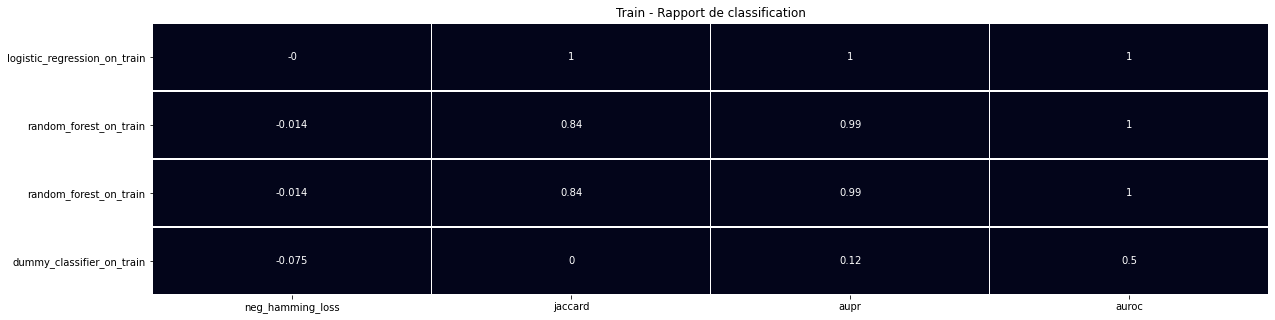

In [146]:
cr = classification_report[classification_report.index.str.contains('train$')].sort_values(by=['jaccard'], ascending=False)

fig, ax = plt.subplots(figsize=(20,5))
plt.title('Train - Rapport de classification')
sns.heatmap(cr, vmin=classification_report.max().max(), vmax=classification_report.max().max(), annot=True, cbar=None,linewidths=.5)

<AxesSubplot:title={'center':'Val - Rapport de classification'}>

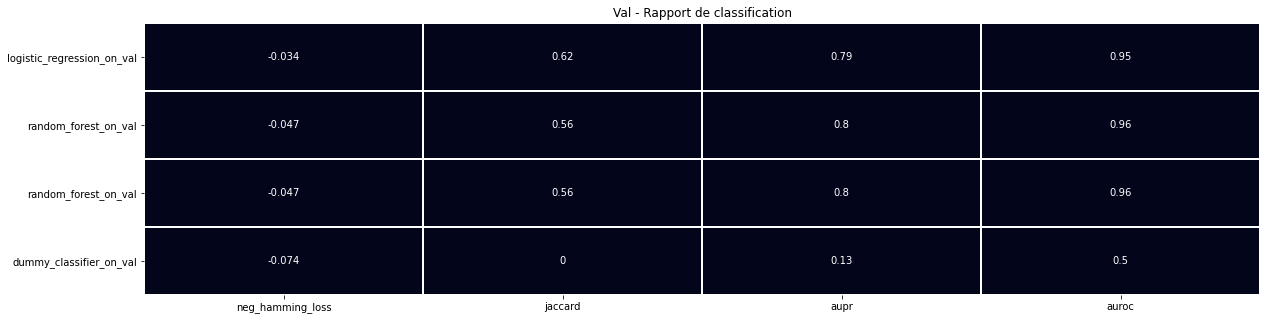

In [147]:
cr = classification_report[classification_report.index.str.contains('val$')].sort_values(by=['jaccard'], ascending=False)

fig, ax = plt.subplots(figsize=(20,5))
plt.title('Val - Rapport de classification')
sns.heatmap(cr, vmin=classification_report.max().max(), vmax=classification_report.max().max(), annot=True, cbar=None,linewidths=.5)

**fonction pour api prediction**

In [59]:
# retourne les étiquettes pour les predictions
def labels(predictions, labels):
    preds = []
    for prediction in predictions:
        pred = []
        for i, is_label in enumerate(prediction):
            if is_label == 0:
                pass
            else :
                pred.append(labels[i])
        preds.append(pred)
    return preds
        
labels(y_pred_val, labels=tags.columns.tolist())

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],


In [60]:
y_pred_val.shape

(500, 20)

**export modele pour api prediction**

In [61]:
import pickle

#model
filename = 'logistic_regression.sav'
pickle.dump(gscv_logistic_regression, open(filename, 'wb'))

#vectorizer
filename = 'multi_tfidf_vectorizer.sav'
pickle.dump(multi_tfidf_vectorizer, open(filename, 'wb'))

In [62]:
#labels
my_labels = pd.Series(tags.columns.tolist())
my_labels.to_csv("data/my_labels.csv", index=False)

In [63]:
y_true = np.array([[1, 1, 1],
                   [1, 0, 1],
                   [1, 1, 0]])
y_pred = np.array([[0, 1, 0],
                   [0, 1, 1],
                   [1, 1, 0]])

In [64]:
jaccard_score(y_true, y_pred, average="weighted")

0.47619047619047616

In [65]:
from sklearn.metrics import hamming_loss

hamming_loss(y_true, y_pred)

0.4444444444444444

In [68]:
(2/3 +1/3 +0/3)/3

0.3333333333333333

In [69]:
4/9


0.4444444444444444